In [188]:
import pandas as pd
import gc
import numpy as np
import math
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as stats
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import datetime
import re
import shap

from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import catboost
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline

# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import cufflinks
import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
cufflinks.go_offline(connected=True)


import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

import os

#### Functions

In [189]:
def make_corr(variables, data, figsize=(10, 15)):
    if isinstance(variables, pd.DataFrame):
        variables = variables['Column Name'].tolist()

    cols = variables

    corr_matrix = data[cols].corr()

    # Create a heatmap with the specified figsize
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, cmap='RdBu_r', annot=True, center=0.0)

    plt.title('Correlation Heatmap for Columns Starting with C')
    plt.show()
    
# We will focus on each column in detail
# Uniqe Values, DTYPE, NUNIQUE, NULL_RATE
def column_details(regex, df):
  
    global columns
    columns=[col for col in df.columns if re.search(regex, col)]

    from colorama import Fore, Back, Style

    print('Unique Values of the Features:\nfeature: DTYPE, NUNIQUE, NULL_RATE\n')
    for i in df[columns]:
        color = Fore.RED if df[i].dtype =='float64' else Fore.BLUE if df[i].dtype =='int64' else Fore.GREEN
        print(f'{i}: {color} {df[i].dtype}, {df[i].nunique()}, %{round(df[i].isna().sum()/len(df[i])*100,2)}\n{Style.RESET_ALL}{pd.Series(df[i].unique()).sort_values().values}\n')

def null_values(df, rate=0):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv['Percentage (%)']>rate].sort_values('Percentage (%)', ascending=False)

#Plot Functions

def plot_col(col, df, figsize=(20, 6)):
    """
    Function to create a pair of subplots containing two graphs based on a specified column.
    
    Left Graph (First Subplot):
    - Draws a bar graph representing the percentage of Fraud cases with respect to the specified column.
    - Uses two colors (0 and 1) to represent Fraud and Non-Fraud cases.
    - Adds a second line graph on the same column, representing the percentage of Fraud cases.

    Right Graph (Second Subplot):
    - Draws a bar graph representing the number of unique values in the dataset based on the specified column.
    
    The purpose of this function is to visualize the relationship between Fraud status and the unique values in a specific column.
    
    :param col: Name of the column to be visualized.
    :param df: Dataset.
    :param figsize: Size of the created figure.
    """
    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True)

    # Left Graph: Bar graph and line graph for Fraud percentages
    plt.subplot(121)
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0: 'NoFraud', 1: 'Fraud'}, inplace=True)

    ax[0] = sns.countplot(x=col, data=df, hue='isFraud', 
                          order=np.sort(df[col].dropna().unique()))
    ax[0].tick_params(axis='x', rotation=90)

    ax_twin = ax[0].twinx()
    ax_twin = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', order=np.sort(df[col].dropna().unique()))

    ax[0].grid()

    # Right Graph: Bar graph for the number of unique values in the column
    plt.subplot(122)
    ax[1] = sns.countplot(x=df[col].dropna(),
                          order=np.sort(df[col].dropna().unique()))

    plt.show()


#correlation functions
# Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return drops


# References:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

def cramers_v(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = sts.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

#outlier functions
def simplify_column(col, df, threshold=0.005, value='mode'):
  df[col] = df[col].replace(df[col].value_counts(dropna=True)[df[col].value_counts(dropna=True, normalize=True)<threshold].index,df[col].mode()[0] if value=='mode' else 'other')
  return df[col]

def identify_collinear_categorical_features(df, columns, threshold):
    """
    Objective:
        Identify collinear categorical features in a dataframe with Cramér's V greater than the threshold.

    Inputs:
        df: dataframe
        columns: list of column names to check for collinearity
        threshold: features with Cramér's V greater than this value are considered collinear

    Output:
        list of columns to drop
    """
    # Create an empty DataFrame to store the results
    cramers_v_matrix = pd.DataFrame(index=columns, columns=columns, dtype=float)

    # Fill in the Cramér's V values for each pair of columns
    for col1 in columns:
        for col2 in columns:
            cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

    # Identify columns to drop based on Cramér's V threshold
    drop_cols = set()
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            if i < j and cramers_v_matrix.loc[col1, col2] > threshold:
                drop_cols.add(col2)

    return list(drop_cols)

def remove_collinear_categorical_features(df, drop_cols):
    """
    Objective:
        Remove collinear categorical features from a dataframe.

    Inputs:
        df: dataframe
        drop_cols: list of columns to drop

    Output:
        dataframe that contains only the non-highly-collinear features
    """
    # Drop the identified columns
    df = df.drop(columns=drop_cols)

    return df

#Encoders
# Frequency Encoding

def frequency_encoding(train, test, columns, self_encoding=False):
    for col in columns:
        df = pd.concat([train[[col]], test[[col]]])
        fq_encode = df[col].value_counts(dropna=False, normalize=True).to_dict()
        if self_encoding:
            train[col] = train[col].map(fq_encode)
            test[col]  = test[col].map(fq_encode)            
        else:
            train[col+'_freq_encoded'] = train[col].map(fq_encode)
            test[col+'_freq_encoded']  = test[col].map(fq_encode)
    return train, test

#Modeling
def plot_feature_importances(model, num=10, figsize=(20,10)):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:num]
    plt.figure(figsize=figsize)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()

In [190]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Check distinct values for each correlated pair
                distinct_values_col = len(x[col[0]].unique())
                distinct_values_row = len(x[row[0]].unique())

                # Keep the one with more distinct values
                if distinct_values_col > distinct_values_row:
                    drop_cols.append(row.values[0])
                else:
                    drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return drops

* Data is separated into two datasets: customer identity information and transaction information. 
* Not all transactions are associated with available identities. 
* Unique key for both tables is TransactionID. It is duplicated in transaction table, it is unique in identity table.

#### Transaction Dataset

In [191]:
# Importing transaction data
# We are standardizing the column types in accordance with the data definition.

# Define column names for the dataset
cols_t = ['TransactionID', 'TransactionDT', 'TransactionAmt',
   'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
   'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
   'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
   'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
   'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
   'M5', 'M6', 'M7', 'M8', 'M9']

# Generate column names for the 'V' features (V1 to V339)
cols_v = ['V'+str(x) for x in range(1, 340)]

# Define data types for the 'V' features as float32
types_v = {c: 'float32' for c in cols_v}

# Specify the columns that need to be converted to the 'object' data type
columns_to_convert_to_object = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
                                'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 
                                'M5', 'M6', 'M7', 'M8', 'M9']

# Read the data from the CSV file into a DataFrame (train)
import zipfile
from pathlib import Path
with zipfile.ZipFile('../dataset/train_transaction.zip', 'r') as zip_file:
   with zip_file.open('train_transaction.csv') as csv_file:
      transaction = pd.read_csv(csv_file,
         usecols=cols_t+['isFraud']+cols_v, 
         dtype={**types_v, **{col: 'object' for col in columns_to_convert_to_object}}, index_col='TransactionID')

In [192]:
# The `TransactionDT` feature represents a timedelta from a specific reference datetime, rather than an actual timestamp. 
# It measures the time elapsed since the reference datetime in a timedelta format.

In [193]:
# Getting a real format of transaction date

# Predefined start date
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

# Define the date range
dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

# Create 'DT' column using the 'TransactionDT' column
transaction['DT'] = transaction['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds=x)))

# Convert 'DT' column to 'DatetimeIndex' object
transaction['DT'] = pd.to_datetime(transaction['DT'])


In [194]:
# Sorting the DataFrame based on the 'DT' column
transaction = transaction.sort_values(by='DT')

#### TRAIN-TEST SPLIT BASED ON TRANSACTION DATE IN TRANSACTION DATA

In [195]:
# Splitting train-test (TRAIN 75% TEST 25%) We will then merge these tables with identity table by using TransactionID.
train_index = transaction.index[:3 * len(transaction) // 4]
test_index = transaction.index[3 * len(transaction) // 4:]

# Splitting train_transaction and test_transaction based on indices
train_transaction = transaction.loc[train_index]
test_transaction = transaction.loc[test_index]

In [196]:
train_transaction.head()

isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  \
TransactionID                                                                   
2987000              0          86400            68.5         W  13926    NaN   
2987001              0          86401            29.0         W   2755  404.0   
2987002              0          86469            59.0         W   4663  490.0   
2987003              0          86499            50.0         W  18132  567.0   
2987004              0          86506            50.0         H   4497  514.0   

               card3       card4  card5   card6  ... V331 V332  V333  V334  \
TransactionID                                    ...                         
2987000        150.0    discover  142.0  credit  ...  NaN  NaN   NaN   NaN   
2987001        150.0  mastercard  102.0  credit  ...  NaN  NaN   NaN   NaN   
2987002        150.0        visa  166.0   debit  ...  NaN  NaN   NaN   NaN   
2987003        150.0  mastercard  117.0   debit  ...  NaN  NaN   NaN   NaN   
2987004        150.0  mastercard  102.0  credit  ...  0.0  0.0   0.0   0.0   

              V335 V336  V337  V338  V339                  DT  
TransactionID                                                  
2987000        NaN  NaN   NaN   NaN   NaN 2017-12-01 00:00:00  
2987001        NaN  NaN   NaN   NaN   NaN 2017-12-01 00:00:01  
2987002        NaN  NaN   NaN   NaN   NaN 2017-12-01 00:01:09  
2987003        NaN  NaN   NaN   NaN   NaN 2017-12-01 00:01:39  
2987004        0.0  0.0   0.0   0.0   0.0 2017-12-01 00:01:46  

[5 rows x 394 columns]

#### Identity Dataset

In [197]:
# Importing identity data
# Define column names for the dataset
cols_t = ['TransactionID','DeviceInfo','DeviceType','id_38','id_37','id_36','id_35','id_34','id_33','id_32','id_31','id_30','id_29','id_28',
          'id_27','id_26','id_25','id_24','id_23','id_22','id_21','id_20','id_19','id_18','id_17','id_16','id_15','id_14','id_13',
          'id_12','id_11','id_10','id_09','id_08','id_07','id_06','id_05','id_04','id_03','id_02','id_01']

# Specify the columns that need to be converted to the 'object' data type
columns_to_convert_to_object = ['DeviceInfo','DeviceType','id_38','id_37','id_36','id_35','id_34','id_33','id_32','id_31','id_30','id_29','id_28',
          'id_27','id_26','id_25','id_24','id_23','id_22','id_21','id_20','id_19','id_18','id_17','id_16','id_15','id_14','id_13',
          'id_12']

# Read the data
import zipfile
from pathlib import Path
with zipfile.ZipFile('../dataset/train_identity.zip', 'r') as zip_file:
    with zip_file.open('train_identity.csv') as csv_file:
        identity = pd.read_csv(
            csv_file,
            usecols=cols_t,
            dtype=dict.fromkeys(columns_to_convert_to_object, 'object'), 
            index_col='TransactionID'
        )

In [198]:
identity.head()

id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
TransactionID                                                              
2987004          0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
2987008         -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2987010         -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
2987011         -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
2987016          0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

               id_09  id_10  ...                id_31 id_32      id_33  \
TransactionID                ...                                         
2987004          NaN    NaN  ...  samsung browser 6.2  32.0  2220x1080   
2987008          NaN    NaN  ...   mobile safari 11.0  32.0   1334x750   
2987010          0.0    0.0  ...          chrome 62.0   NaN        NaN   
2987011          NaN    NaN  ...          chrome 62.0   NaN        NaN   
2987016          0.0    0.0  ...          chrome 62.0  24.0   1280x800   

                        id_34 id_35 id_36 id_37 id_38 DeviceType  \
TransactionID                                                      
2987004        match_status:2     T     F     T     T     mobile   
2987008        match_status:1     T     F     F     T     mobile   
2987010                   NaN     F     F     T     T    desktop   
2987011                   NaN     F     F     T     T    desktop   
2987016        match_status:2     T     F     T     T    desktop   

                                  DeviceInfo  
TransactionID                                 
2987004        SAMSUNG SM-G892A Build/NRD90M  
2987008                           iOS Device  
2987010                              Windows  
2987011                                  NaN  
2987016                                MacOS  

[5 rows x 40 columns]

In [199]:
# Check for duplicated Transaction IDs when TransactionID is the index - all transaction ids unique in identity table, this will be elobrated while merging the datasets
print('Length of Transaction IDs:', identity.index.shape[0])
print('Number of unique Transaction IDs:', identity.index.nunique())


Length of Transaction IDs: 144233
Number of unique Transaction IDs: 144233


#### Merging Transaction and Identity Data

In [200]:
# Merging datas

# Merge train_transaction and identity
train = pd.merge(train_transaction, identity, how='left', left_index=True, right_index=True)

# Merge test_transaction and identity
test = pd.merge(test_transaction, identity, how='left', left_index=True, right_index=True)

print("Train: ", train.shape)
print("Test: ", test.shape)

# Delete transaction, train_transaction, test_transaction, identity
del transaction, train_transaction, test_transaction, identity


Train:  (442905, 434)
Test:  (147635, 434)


In [201]:
# Train start-end date
print('min Transaction Date: ',min(train['DT'].values))
print('max Transaction Date: ',max(train['DT'].values))

min Transaction Date:  2017-12-01T00:00:00.000000000
max Transaction Date:  2018-04-09T04:03:25.000000000


In [202]:
# Test start-end date
print('min Transaction Date: ',min(test['DT'].values))
print('max Transaction Date: ',max(test['DT'].values))

min Transaction Date:  2018-04-09T04:04:25.000000000
max Transaction Date:  2018-05-31T23:58:51.000000000


In [203]:
# Check for the duplicated dates-train
print('length of Transaction Date',train['DT'].shape[0] )
print('length of unique Transaction Date', train['DT'].nunique())

length of Transaction Date 442905
length of unique Transaction Date 429087


In [204]:
# Check for the duplicated dates-test
print('length of Transaction Date',test['DT'].shape[0] )
print('length of unique Transaction Date', test['DT'].nunique())

length of Transaction Date 147635
length of unique Transaction Date 144262


In [205]:
train.head()

isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  \
TransactionID                                                                   
2987000              0          86400            68.5         W  13926    NaN   
2987001              0          86401            29.0         W   2755  404.0   
2987002              0          86469            59.0         W   4663  490.0   
2987003              0          86499            50.0         W  18132  567.0   
2987004              0          86506            50.0         H   4497  514.0   

               card3       card4  card5   card6  ...                id_31  \
TransactionID                                    ...                        
2987000        150.0    discover  142.0  credit  ...                  NaN   
2987001        150.0  mastercard  102.0  credit  ...                  NaN   
2987002        150.0        visa  166.0   debit  ...                  NaN   
2987003        150.0  mastercard  117.0   debit  ...                  NaN   
2987004        150.0  mastercard  102.0  credit  ...  samsung browser 6.2   

              id_32      id_33           id_34 id_35 id_36  id_37  id_38  \
TransactionID                                                              
2987000         NaN        NaN             NaN   NaN   NaN    NaN    NaN   
2987001         NaN        NaN             NaN   NaN   NaN    NaN    NaN   
2987002         NaN        NaN             NaN   NaN   NaN    NaN    NaN   
2987003         NaN        NaN             NaN   NaN   NaN    NaN    NaN   
2987004        32.0  2220x1080  match_status:2     T     F      T      T   

               DeviceType                     DeviceInfo  
TransactionID                                             
2987000               NaN                            NaN  
2987001               NaN                            NaN  
2987002               NaN                            NaN  
2987003               NaN                            NaN  
2987004            mobile  SAMSUNG SM-G892A Build/NRD90M  

[5 rows x 434 columns]

In [206]:
# Performing garbage collection to release memory occupied by unused objects
gc.collect()


57

In [207]:
#pickling datasets
#Save 'train' data to a pickle file named 'train_1.pkl'
train.to_pickle(r'../dataset/train_1.pkl')

#save 'test' data to a pickle file named 'test_1.pkl'
test.to_pickle(r'../dataset/test_1.pkl')

In [208]:
# Read the 'train_1.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('../dataset/train_1.pkl')

# Read the 'test_1.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('../dataset/test_1.pkl')

In [209]:
# Just to preserve the original train I did below. original train will be now train_original

# Copy the DataFrame and rename it
train_copy = train.copy()  # Create a copy of the original DataFrame and name it train_copy
train_original = train.copy()  # Create another copy of the original DataFrame and name it train_original

# Rename train by assigning the copy's content to it
train = train_copy.copy()  # Rename train by assigning the content of train_copy to it


#### **Target Variable Distribution**

The original dataset is characterized by a significant class imbalance, predominantly consisting of non-fraudulent transactions. This imbalance, where only 3.5% of transactions are labeled as fraud, poses a challenge for developing accurate predictive models and conducting analyses. Utilizing such an imbalanced dataset as the basis for machine learning models may lead to substantial errors and the risk of overfitting.

The risk of overfitting arises from the potential for algorithms to incorrectly assume that the majority of transactions are not fraudulent. In contrast to making assumptions, the primary objective is to develop models capable of identifying patterns indicative of fraudulent activities.

In the machine learning context, class imbalance denotes a considerable disparity in the number of data points representing different classes. Addressing this imbalance is paramount to ensure that models are not misled by the prevalence of non-fraudulent instances. The goal is to enable models to accurately identify patterns associated with fraudulent transactions.

In the training set, approximately 96.49% of transactions are labeled as non-fraudulent (isFraud==0), while around 3.51% are identified as fraudulent (isFraud==1). Similarly, in the test set, approximately 96.55% of transactions are non-fraudulent, and about 3.45% are labeled as fraudulent.

This class distribution indicates a high prevalence of non-fraudulent transactions in both the training and test sets, with a relatively small percentage of transactions being classified as fraudulent. This reinforces the presence of a significant class imbalance, which should be considered when developing and evaluating predictive models.


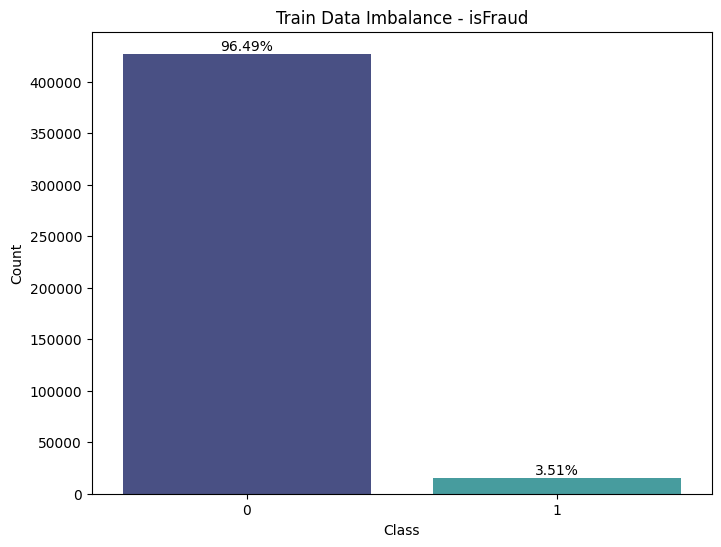

In [210]:
# Train Data
# Count the occurrences of each class in the 'isFraud' column
class_counts = train['isFraud'].value_counts()

# Calculate the percentage distribution
class_percentages = class_counts / len(train) * 100

# Plot the class distribution using Matplotlib
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="mako")

# Adding percentages above the bars
for i, value in enumerate(class_counts.values):
    plt.text(i, value + 50, f'{class_percentages[i]:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

plt.title("Train Data Imbalance - isFraud")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


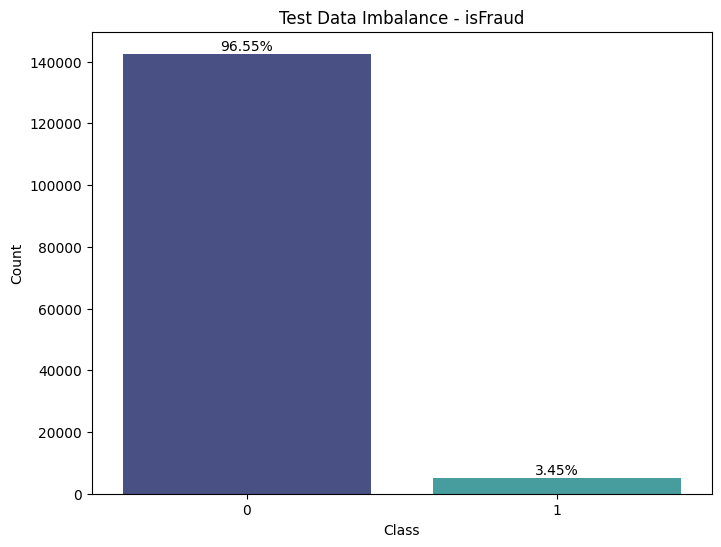

In [211]:
# Test Data
# Count the occurrences of each class in the 'isFraud' column
class_counts = test['isFraud'].value_counts()

# Calculate the percentage distribution
class_percentages = class_counts / len(test) * 100

# Plot the class distribution using Matplotlib
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="mako")

# Adding percentages above the bars
for i, value in enumerate(class_counts.values):
    plt.text(i, value + 50, f'{class_percentages[i]:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

plt.title("Test Data Imbalance - isFraud")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [212]:
del class_counts
gc.collect()

5632

#### Handling Missing Values, Feature Elimination By 3 Criterias

Datasets have too much missing values.

In [213]:
# Total missing values of the train data
missing_count = train.isnull().sum()
cell_counts = np.product(train.shape)
missing_sum = missing_count.sum()
print ("%",(round(missing_sum/cell_counts,2)) * 100)

% 45.0


In [214]:
# Total missing values of the test data
missing_count = test.isnull().sum()
cell_counts = np.product(test.shape)
missing_sum = missing_count.sum()
print ("%",(round(missing_sum/cell_counts,2)) * 100)

% 45.0


In [215]:
# columns with no nulls of train (20 columns have no nulls, rest have)
null_counts = train.isnull().sum()

columns_with_no_null = null_counts[null_counts == 0].index

print("\nColumns with No Null Values-train:")
print(columns_with_no_null)



Columns with No Null Values-train:
Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'DT'],
      dtype='object')


In [216]:
# columns with no nulls of test
null_counts = test.isnull().sum()

columns_with_no_null = null_counts[null_counts == 0].index

print("\nColumns with No Null Values-test:")
print(columns_with_no_null)


Columns with No Null Values-test:
Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'V279', 'V280', 'V284', 'V285', 'V286', 'V287',
       'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V297', 'V298', 'V299',
       'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310',
       'V311', 'V312', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'DT'],
      dtype='object')


In [217]:
del missing_count, cell_counts, missing_sum, null_counts, columns_with_no_null


It has been observed that a significant number of columns exhibit a pattern of "correlated missing values," where certain rows share missing values in corresponding positions across multiple columns.
Most of them are in the same variable group, this will be a clue for highly correlated variables in the same groups to eliminate later.


In [218]:
# Check for null percentage correlated columns-train
# Create a dictionary to store columns with null percentages > 10%
null_percentage_dict = {}
nan_counts = train.isnull().sum()

for col in train.columns:
    null_percent = (nan_counts[col] / len(train)) * 100
    if null_percent >= 10:
        null_percentage_dict[null_percent] = null_percentage_dict.get(null_percent, []) + [col]

# Sort the dictionary by null percentages
sorted_null_percentage_dict = {k: v for k, v in sorted(null_percentage_dict.items(), reverse=True)}

for null_percent, columns in sorted_null_percentage_dict.items():
    print(f"####### Null Percentage = {null_percent:.2f}%")
    print(columns)


####### Null Percentage = 99.16%
['id_24']
####### Null Percentage = 99.08%
['id_25']
####### Null Percentage = 99.08%
['id_07', 'id_08']
####### Null Percentage = 99.08%
['id_26']
####### Null Percentage = 99.08%
['id_21']
####### Null Percentage = 99.08%
['id_22', 'id_23', 'id_27']
####### Null Percentage = 93.60%
['D7']
####### Null Percentage = 93.11%
['dist2']
####### Null Percentage = 91.95%
['id_18']
####### Null Percentage = 89.48%
['D13']
####### Null Percentage = 89.29%
['D14']
####### Null Percentage = 88.68%
['D12']
####### Null Percentage = 88.37%
['id_03', 'id_04']
####### Null Percentage = 87.44%
['D6']
####### Null Percentage = 86.74%
['D8', 'D9', 'id_09', 'id_10']
####### Null Percentage = 86.57%
['id_33']
####### Null Percentage = 85.60%
['id_30']
####### Null Percentage = 85.60%
['id_32']
####### Null Percentage = 85.59%
['id_34']
####### Null Percentage = 85.14%
['id_14']
####### Null Percentage = 84.82%
['V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145

In [219]:
# Check for null percentage correlated columns-test
# Create a dictionary to store columns with null percentages > 10%
null_percentage_dict = {}
nan_counts = test.isnull().sum()

for col in test.columns:
    null_percent = (nan_counts[col] / len(test)) * 100
    if null_percent >= 10:
        null_percentage_dict[null_percent] = null_percentage_dict.get(null_percent, []) + [col]

# Sort the dictionary by null percentages
sorted_null_percentage_dict = {k: v for k, v in sorted(null_percentage_dict.items(), reverse=True)}

for null_percent, columns in sorted_null_percentage_dict.items():
    print(f"####### Null Percentage = {null_percent:.2f}%")
    print(columns)

####### Null Percentage = 99.32%
['id_24']
####### Null Percentage = 99.27%
['id_25']
####### Null Percentage = 99.26%
['id_21']
####### Null Percentage = 99.26%
['id_07', 'id_08']
####### Null Percentage = 99.26%
['id_22', 'id_23', 'id_26', 'id_27']
####### Null Percentage = 95.18%
['dist2']
####### Null Percentage = 93.59%
['id_18']
####### Null Percentage = 92.84%
['D7']
####### Null Percentage = 90.65%
['id_30']
####### Null Percentage = 90.65%
['id_32', 'id_33']
####### Null Percentage = 90.53%
['id_34']
####### Null Percentage = 90.35%
['id_14']
####### Null Percentage = 90.11%
['D12']
####### Null Percentage = 90.04%
['V138', 'V139', 'V140', 'V141', 'V142', 'V146', 'V147', 'V148', 'V149', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V161', 'V162', 'V163']
####### Null Percentage = 90.04%
['V143', 'V144', 'V145', 'V150', 'V151', 'V152', 'V159', 'V160', 'V164', 'V165', 'V166']
####### Null Percentage = 90.02%
['D14']
####### Null Percentage = 89.98%
['V322', 'V323', 'V324', 'V

In [220]:
# Drop columns by using 3 criteria:
# 1. If a column only has only one distinct value
# 2. If a column has more than 90% null values
# 3. If one of the categories in a column dominates more than 90% of the column
# we are looking for these criterias in train, then dropping the columns from both train and test

# Initialize lists to store columns to be dropped based on different criteria
one_value_cols, many_null_cols, big_top_value_cols = [], [], []

# Iterate through only the train DataFrame
for df in [train]:
    # Identify columns with only one distinct value
    one_value_cols += [col for col in df.columns if df[col].nunique() == 1]
    
    # Identify columns with more than 90% null values
    many_null_cols += [col for col in df.columns if df[col].isnull().sum() / df.shape[0] > 0.9]
    
    # Identify columns where a single value dominates more than 90%
    big_top_value_cols += [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

# Combine the lists of columns to be dropped, removing duplicates using set
cols_to_drop = list(set(one_value_cols + many_null_cols + big_top_value_cols))

# Check if 'isFraud' is in the list of columns to be dropped, and remove it if present
if 'isFraud' in cols_to_drop:
    cols_to_drop.remove('isFraud')

# Drop the identified columns from the train DataFrame
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

# Print the number of features that are going to be dropped for being considered useless
print(f'{len(cols_to_drop)} features are going to be dropped for being useless')


66 features are going to be dropped for being useless


#### **Transaction Date**

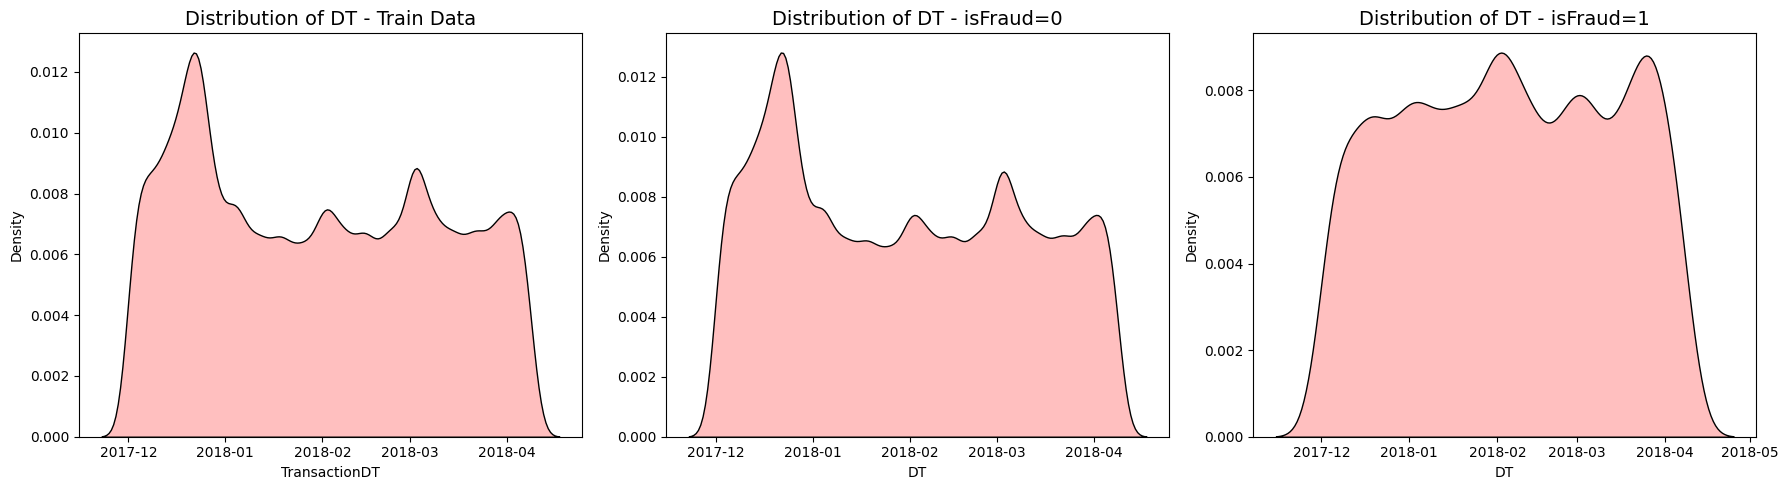

In [221]:
# TransactionDT Dist for Train Transaction Data - Whole Data
time_val_whole = train['DT'].values

# Create a figure
plt.figure(figsize=(18, 5))

# Create a distribution plot for TransactionDT column - Train Data
plt.subplot(1, 3, 1)  # 1 row, 3 columns, plot at position 1
sns.kdeplot(time_val_whole, color='r', fill=True, edgecolor='black')
plt.title('Distribution of DT - Train Data', fontsize=14)
plt.xlabel('TransactionDT')

# TransactionDT Dist for Train - isFraud=0
time_val_no_fraud = train['DT'][train['isFraud'] == 0]

# TransactionDT Dist for Train - isFraud=1
time_val_fraud = train['DT'][train['isFraud'] == 1]

# Create subplots for isFraud=0 and isFraud=1
for i, time_val in enumerate([time_val_no_fraud, time_val_fraud], start=2):
    plt.subplot(1, 3, i)
    sns.kdeplot(time_val, color='r', fill=True, edgecolor='black')
    plt.title(f'Distribution of DT - isFraud={i-2}', fontsize=14)
    plt.xlabel('DT')
    

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

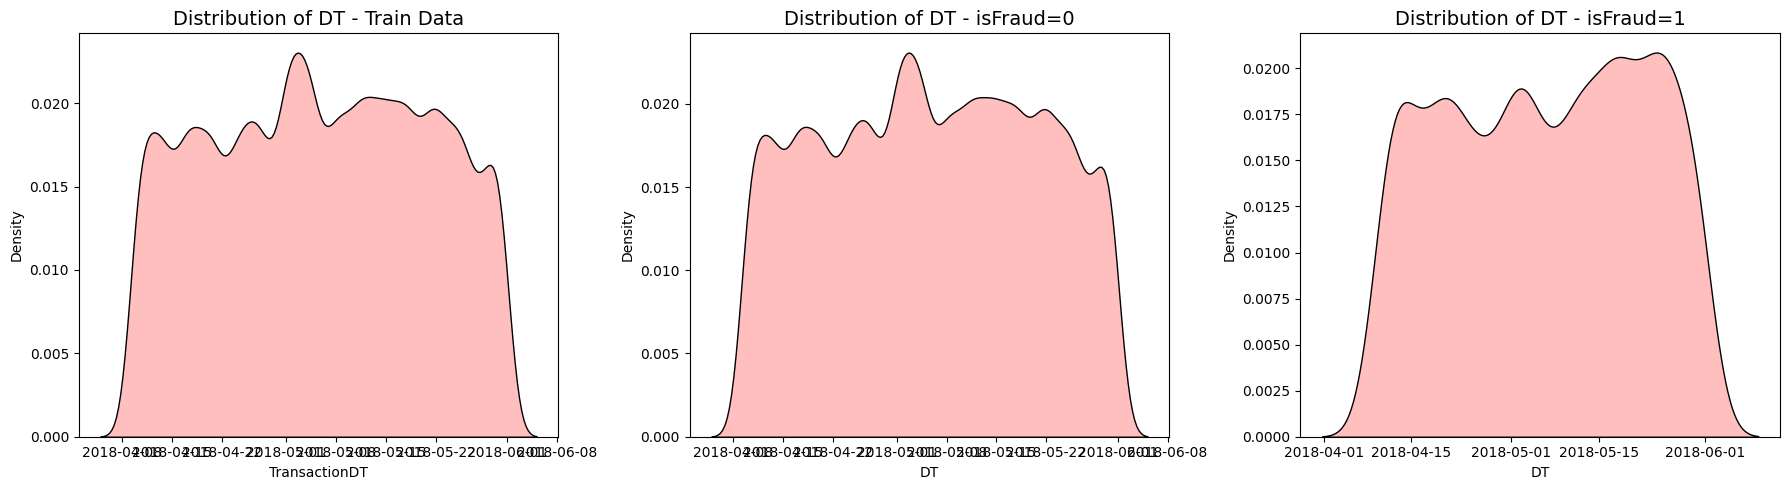

In [222]:
# TransactionDT Dist for Train Transaction Data - Whole Data
time_val_whole = test['DT'].values

# Create a figure
plt.figure(figsize=(18, 5))

# Create a distribution plot for TransactionDT column - Whole Data
plt.subplot(1, 3, 1)  # 1 row, 3 columns, plot at position 1
sns.kdeplot(time_val_whole, color='r', fill=True, edgecolor='black')
plt.title('Distribution of DT - Train Data', fontsize=14)
plt.xlabel('TransactionDT')

# TransactionDT Dist for Train Transaction Data - isFraud=0
time_val_no_fraud = test['DT'][test['isFraud'] == 0]

# TransactionDT Dist for Train Transaction Data - isFraud=1
time_val_fraud = test['DT'][test['isFraud'] == 1]

# Create subplots for isFraud=0 and isFraud=1
for i, time_val in enumerate([time_val_no_fraud, time_val_fraud], start=2):
    plt.subplot(1, 3, i)
    sns.kdeplot(time_val, color='r', fill=True, edgecolor='black')
    plt.title(f'Distribution of DT - isFraud={i-2}', fontsize=14)
    plt.xlabel('DT')
    

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### **Transaction Amount**

In [223]:
column_details(regex='TransactionAmt', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

TransactionAmt:  float64, 17111, %0.0
[2.5100000e-01 2.7200000e-01 2.9200000e-01 ... 6.0852300e+03 6.4509700e+03
 3.1937391e+04]



Text(0.5, 1.0, 'Test')

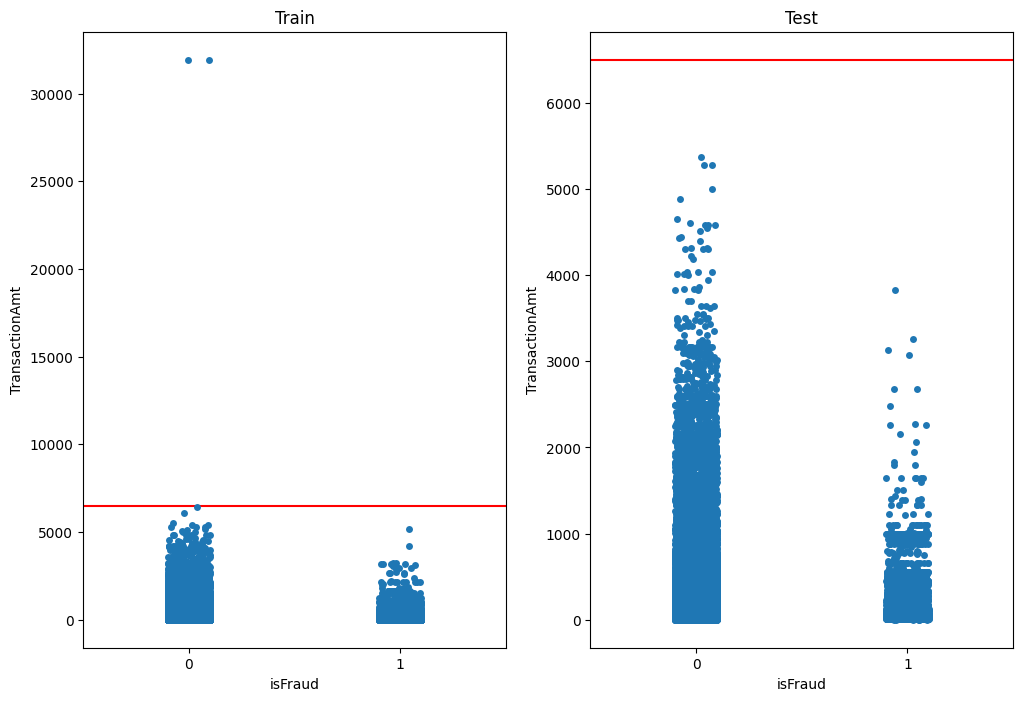

In [224]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='TransactionAmt', x='isFraud', data=train)
plt.axhline(6500, color='red')
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='TransactionAmt', x='isFraud', data=test)
plt.axhline(6500, color='red')
plt.title('Test')

In [225]:
max_transaction_amount = train['TransactionAmt'][train['TransactionAmt'] < 30000].max()
print(f"The maximum transaction amount below 30000 is: {max_transaction_amount}")


The maximum transaction amount below 30000 is: 6450.97


There are outliers in Transaction_Amount with isFraud == 0. These amounts are above 30k. 
We find the maximum amount below 30k ( 6450.97 ). We will capped the Train transaction with 6450.97 below code.

In [226]:
# Identify transactions with isFraud == 0 and TransactionAmt above 6450.97
condition = train['TransactionAmt'] > 6450.97

# Cap the TransactionAmt at 5368 for the identified transactions
train.loc[condition, 'TransactionAmt'] = 6450.97

In [227]:
train['TransactionAmt'].max()

6450.97

In [228]:
print('Avg Transaction Amount by Frauds-Train', train[train.isFraud==1]['TransactionAmt'].mean())
print('Avg Transaction Amount by Non-Frauds-Train', train[train.isFraud==0]['TransactionAmt'].mean())
print('Avg Transaction Amount-Train',train['TransactionAmt'].mean())
print('Avg Transaction Amount-Test', test['TransactionAmt'].mean() )

Avg Transaction Amount by Frauds-Train

 147.32386647818544
Avg Transaction Amount by Non-Frauds-Train 133.7389101726486
Avg Transaction Amount-Train 134.2162646278547
Avg Transaction Amount-Test 137.11464901954145


The averages of TransactionAmt of train and test datasets are nearly same. The average of the fraud transactions(147.32) is bigger than the average of the non-fraud transactions(133.73).
The average transaction amount for fraudulent transactions appears to be higher than that for legitimate transactions. Statistically, the average transaction amount for fraudulent transactions is 147.32 units, whereas the average amount for legitimate transactions is 133.74 units. This observation indicates that fraudulent transactions tend to involve higher amounts

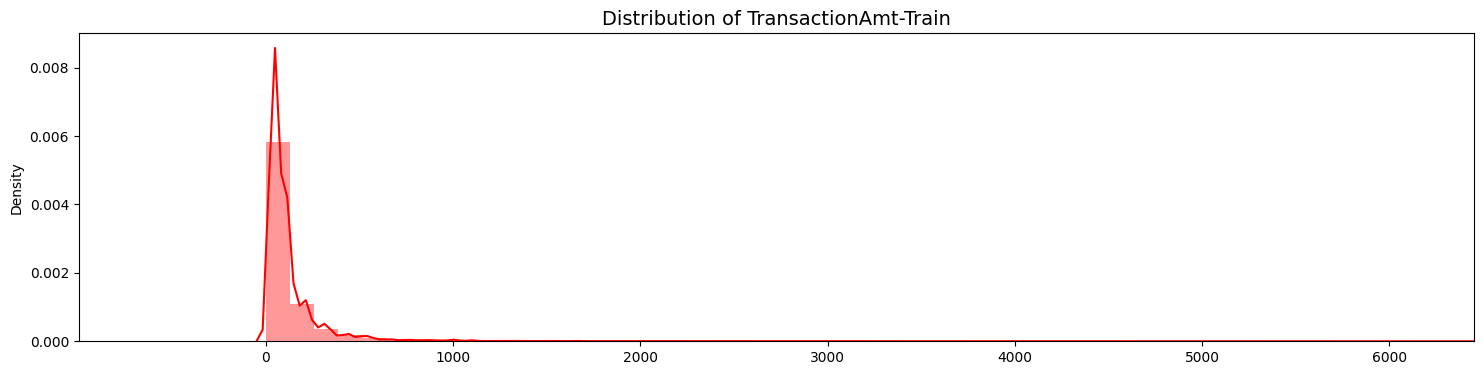

In [229]:
#Distribution of TransactionAmt-Train
time_val = train['TransactionAmt'].values

plt.figure(figsize=(18, 4))
sns.distplot(time_val, color='r')
plt.title('Distribution of TransactionAmt-Train', fontsize=14)
plt.xlim([min(time_val)-1000, max(time_val)])  

# Show the plot
plt.show()

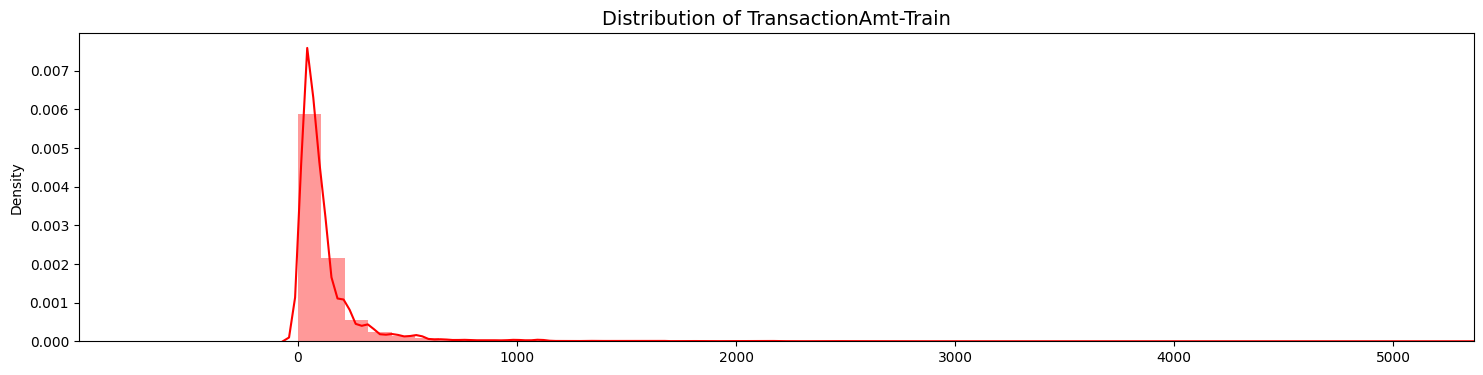

In [230]:
#Distribution of TransactionAmt-Train
time_val = test['TransactionAmt'].values

plt.figure(figsize=(18, 4))
sns.distplot(time_val, color='r')
plt.title('Distribution of TransactionAmt-Train', fontsize=14)
plt.xlim([min(time_val)-1000, max(time_val)])  

# Show the plot
plt.show()

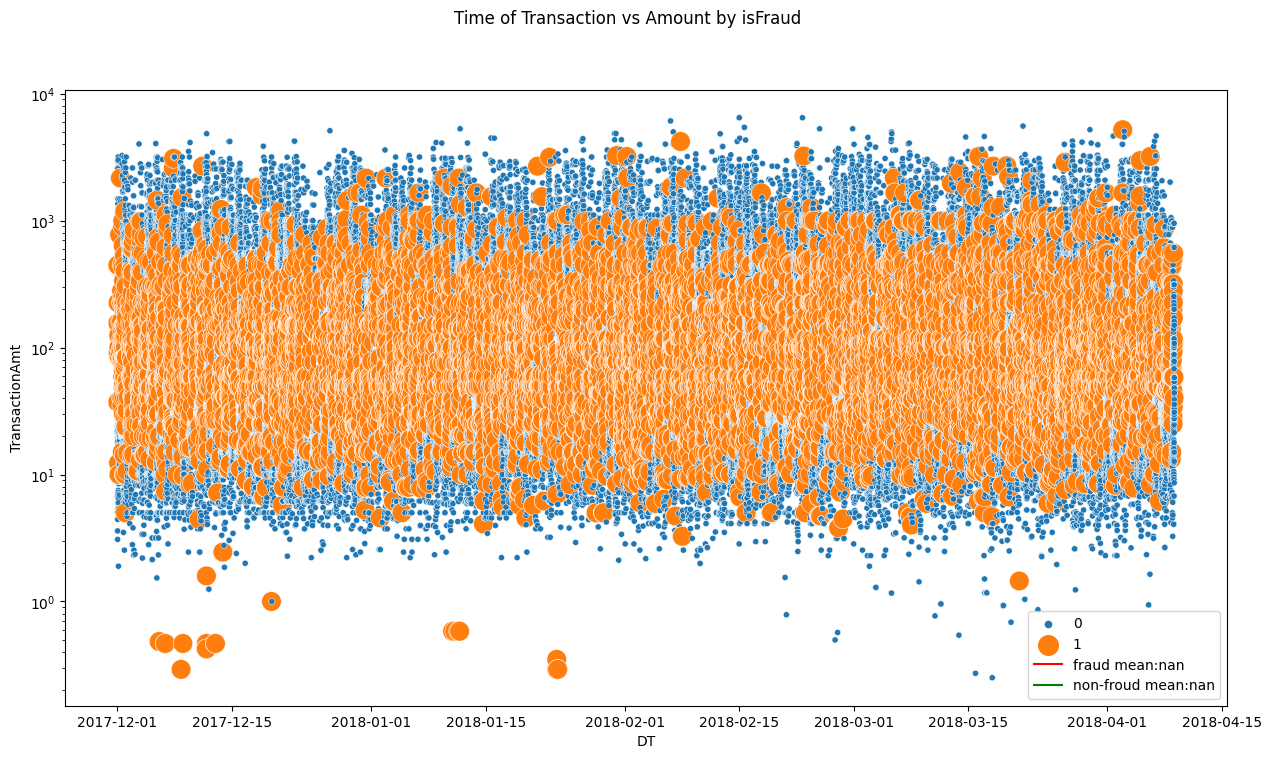

In [231]:
plt.figure(figsize=(15,8))
plt.suptitle('Time of Transaction vs Amount by isFraud')
fraud_mean, nonfraud_mean = train[train.isFraud=='1']['TransactionAmt'].mean(), train[train.isFraud=='0']['TransactionAmt'].mean()
sns.scatterplot(x=train['DT'], y=train['TransactionAmt'], data=train, hue='isFraud', size="isFraud", sizes=(200, 20))
plt.axhline(y=fraud_mean ,color='red',label=f'fraud mean:{round(fraud_mean,2)}')
plt.axhline(y=nonfraud_mean, color='green',label=f'non-froud mean:{round(nonfraud_mean,2)}')
plt.legend()

plt.yscale('log')
plt.show()

#### ProductCD : product code, the product for each transaction (nominal categorical)

In [232]:
for df in [train, test]:
  column_details(regex='ProductCD', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

ProductCD:  object, 5, %0.0
['C' 'H' 'R' 'S' 'W']

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

ProductCD:  object, 5, %0.0
['C' 'H' 'R' 'S' 'W']



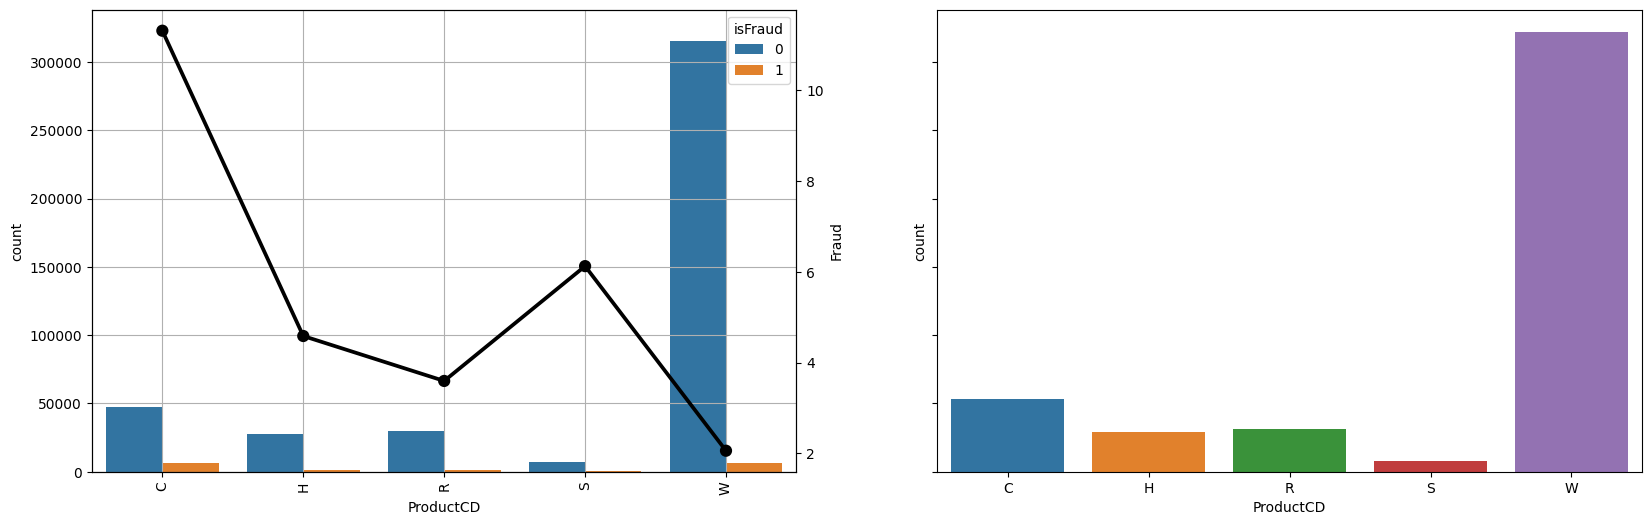

In [233]:
# Distribution of ProductCD column-Train
plot_col('ProductCD', df=train)


In [234]:
train.groupby('ProductCD')['isFraud'].mean()

ProductCD
C    0.113070
H    0.045851
R    0.035957
S    0.061235
W    0.020594
Name: isFraud, dtype: float64

* C, H, R, S, W values are unknown from data definition.

Probably their meaning:
* C (Credit): Credit card transactions
* H (Debit): Debit card or ATM card transactions
* R (Charge Card): Charge card transactions
* S (Cash): Cash transactions
* W (Wallet): Transactions made with digital wallets or payment applications

'W' has the highest frequency, while 'S' has the lowest.
Most fraud activities realized by C product code. (11%) Least fraud activities with W product ccode. (2%) This could indicate that a C product category is more strongly associated with fraud. The probabilities of fraud for other categories (H, R, S, W) are lower, but the contribution of these categories may still be significant. 


In [235]:
# Target Encoding For ProductCD (taking into account the average of the target feature in train set)
temp_dict = train.groupby(['ProductCD'])['isFraud'].agg(['mean']).to_dict()['mean']

train['ProductCD_target_encoded'] = train['ProductCD'].replace(temp_dict)
test['ProductCD_target_encoded']  = test['ProductCD'].replace(temp_dict)

In [236]:
# original 'ProductCD' column dropped
train.drop('ProductCD', axis=1, inplace=True)
test.drop('ProductCD', axis=1, inplace=True)

In [237]:
gc.collect()

29301

#### Card1-Card6 : payment card information, such as card type, card category, issue bank, country (nominal categorical)

In [238]:
column_details(regex='^card\d', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

card1:  object, 12485, %0.0
['1000' '10000' '10003' ... '9997' '9998' '9999']

card2:  object, 500, %1.53
['100.0' '101.0' '102.0' '103.0' '104.0' '105.0' '106.0' '108.0' '109.0'
 '110.0' '111.0' '112.0' '113.0' '114.0' '115.0' '116.0' '117.0' '118.0'
 '119.0' '120.0' '121.0' '122.0' '123.0' '124.0' '125.0' '126.0' '127.0'
 '128.0' '129.0' '130.0' '131.0' '132.0' '133.0' '134.0' '135.0' '136.0'
 '137.0' '138.0' '139.0' '140.0' '141.0' '142.0' '143.0' '144.0' '145.0'
 '146.0' '147.0' '148.0' '149.0' '150.0' '151.0' '152.0' '153.0' '154.0'
 '155.0' '156.0' '157.0' '158.0' '159.0' '160.0' '161.0' '162.0' '163.0'
 '164.0' '165.0' '166.0' '167.0' '168.0' '169.0' '170.0' '171.0' '172.0'
 '173.0' '174.0' '175.0' '176.0' '177.0' '178.0' '179.0' '180.0' '181.0'
 '182.0' '183.0' '184.0' '185.0' '186.0' '187.0' '188.0' '189.0' '190.0'
 '191.0' '192.0' '193.0' '194.0' '195.0' '196.0' '197.0' '198.0' '199.0'
 '200.0' '201.0' '202.0'

In [239]:
cards = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
for i in cards:
    print ("Unique ",i, " = ",train[i].nunique())

Unique  card1  =  12485
Unique  card2  =  500
Unique  card3  =  106
Unique  card4  =  4
Unique  card5  =  111
Unique  card6  =  4


Card4 and Card6 has 4 distinct value, we will observe the distributions of fraud activities in these columns.

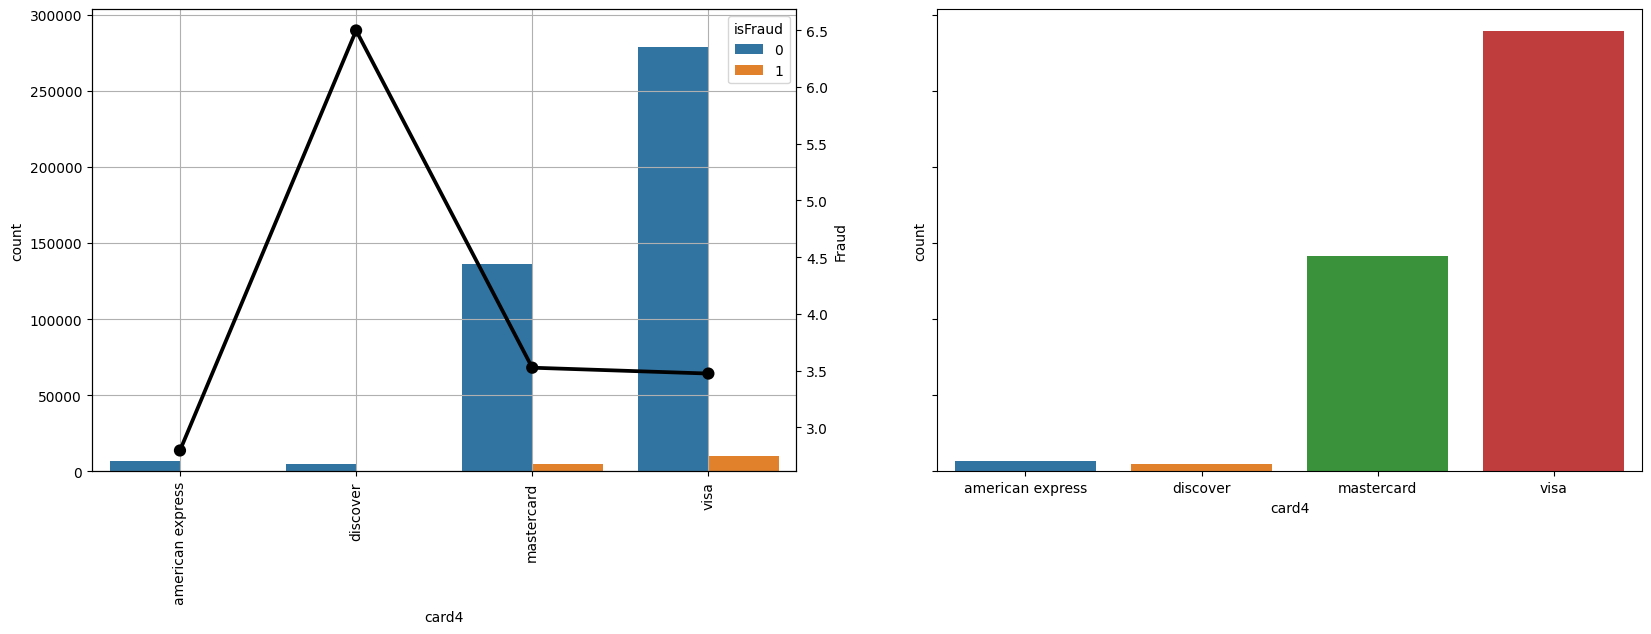

In [240]:
# to show the most used Brand of electronic cards for fraud transactions in the train dataset
plot_col("card4", df=train)

In [241]:
train.groupby('card4')['isFraud'].mean()

card4
american express    0.027966
discover            0.064971
mastercard          0.035260
visa                0.034743
Name: isFraud, dtype: float64

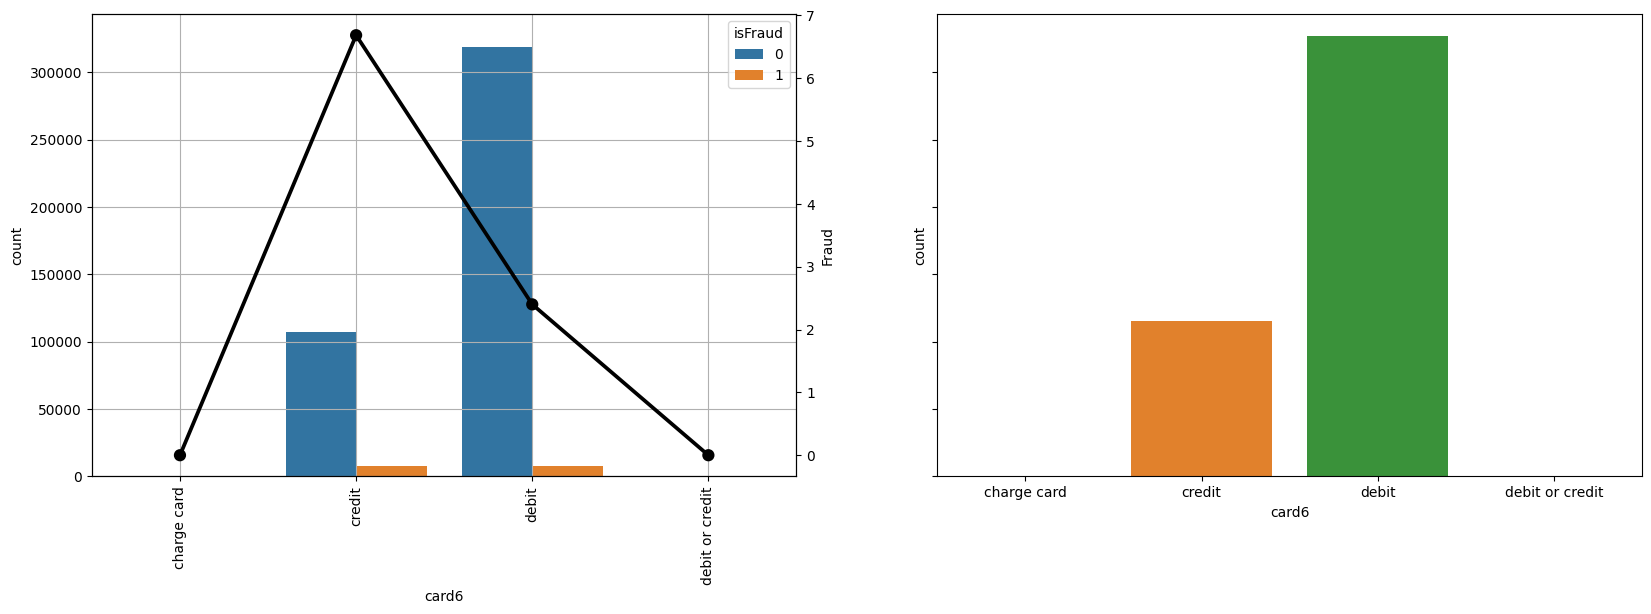

In [242]:
# to show the most used method of transaction with cards for fraud activities in the train dataset
plot_col("card6", df=train)

Card1: The 'Card 1' column, originally designated as categorical, exhibits behavior akin to continuous data, featuring a substantial '13553' unique values.

In [243]:
# identify the differences in the 'card1' column between the 'train' and 'test' DataFrames
# old versions represent the unique values in the 'card1' column that exist in the 'train' but not in the 'test' DataFrame and new versions are vice versa.
old_versions_card1 = set(train['card1'].unique()) - set(test['card1'].unique())
new_versions_card1 = set(test['card1'].unique()) - set(train['card1'].unique())

In [244]:
print("Old versions of card1 (in train but not in test):", old_versions_card1)
print("New versions of card1 (in test but not in train):", new_versions_card1)


Old versions of card1 (in train but not in test): {'9452', '6967', '7167', '11236', '7516', '4740', '5913', '16227', '1636', '11365', '17163', '5598', '6118', '9922', '17530', '9488', '6600', '6607', '14841', '9695', '17494', '12915', '9918', '15273', '15580', '17630', '13556', '5326', '17169', '1150', '17173', '11650', '3896', '11373', '18364', '4621', '14666', '2070', '17693', '8840', '15976', '3685', '2226', '17078', '12831', '9850', '7217', '6370', '14811', '4729', '3826', '12849', '12070', '14826', '3163', '3340', '11156', '3775', '6430', '16231', '1732', '9988', '3969', '4786', '5449', '5744', '9904', '1020', '11354', '13428', '11517', '4182', '9834', '10837', '18108', '4332', '6158', '14860', '5059', '3241', '10295', '17408', '14506', '17700', '9163', '2910', '7200', '6955', '15293', '1285', '3575', '12539', '13184', '10685', '9012', '14529', '16570', '9900', '13729', '7524', '4941', '8824', '3119', '1196', '1780', '4269', '14418', '17419', '8425', '5094', '11557', '15338', '285

In [245]:
len(old_versions_card1), len(new_versions_card1)

(5810, 1068)

In [246]:
# We synchronized test['card1] and train[card1]
# Replace values in 'card1' column of test DataFrame with NaN if they are in new_versions_card1
test['card1'] = test['card1'].apply(lambda x: np.nan if x in new_versions_card1 else x)

# Replace values in 'card1' column of train DataFrame with NaN if they are in old_versions_card1
train['card1'] = train['card1'].apply(lambda x: np.nan if x in old_versions_card1 else x)

<Axes: xlabel='count'>

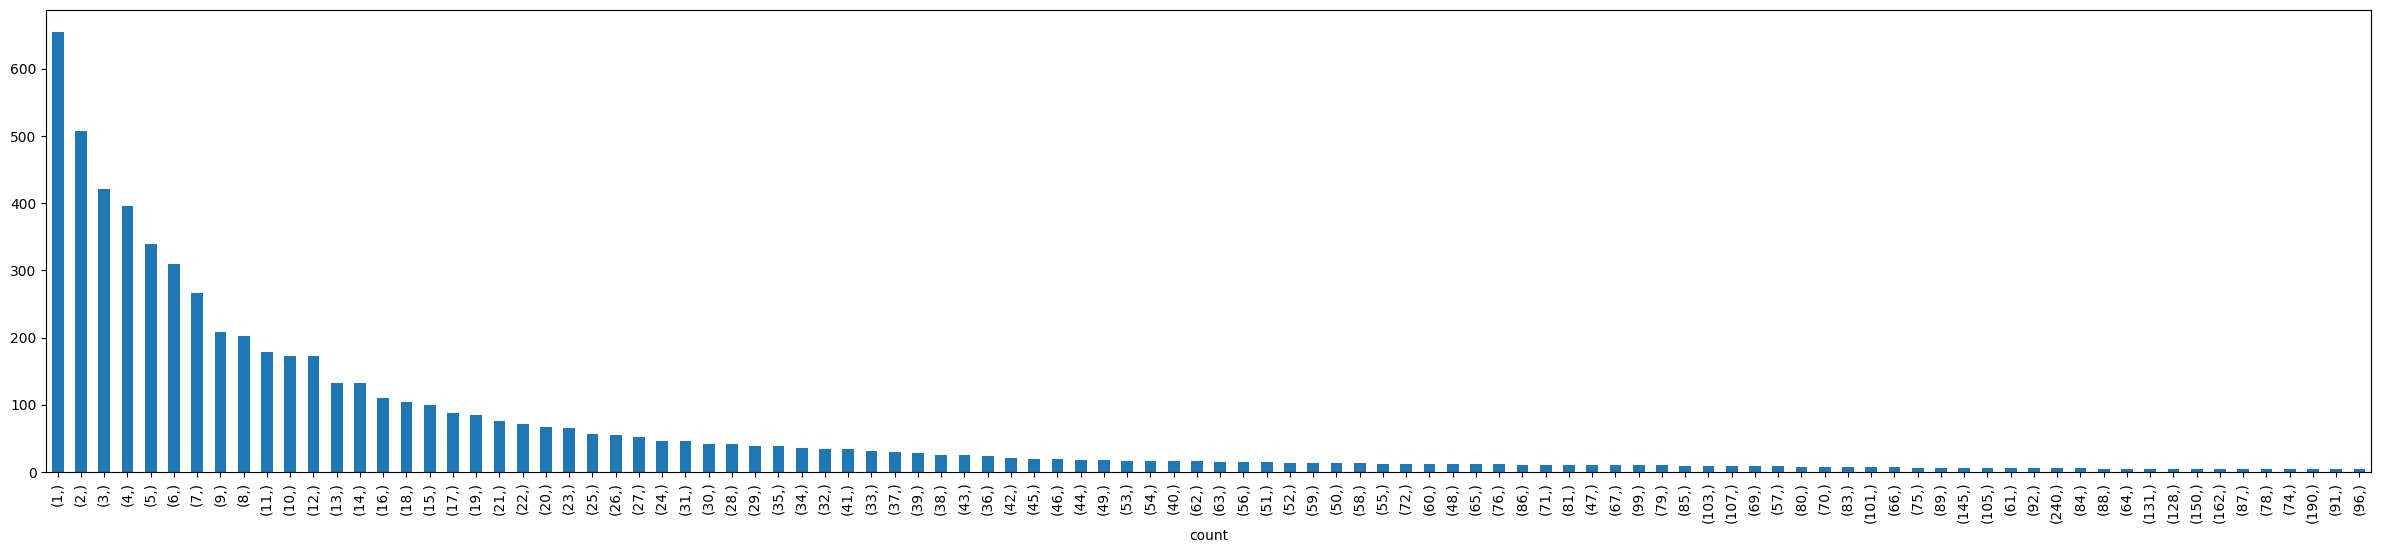

In [247]:
# Countplot of the frequency of the unique value frequencies in card1-train
plt.figure(figsize=(30,6))
train.card1.value_counts().to_frame().value_counts().head(100).plot.bar()

<Axes: xlabel='count'>

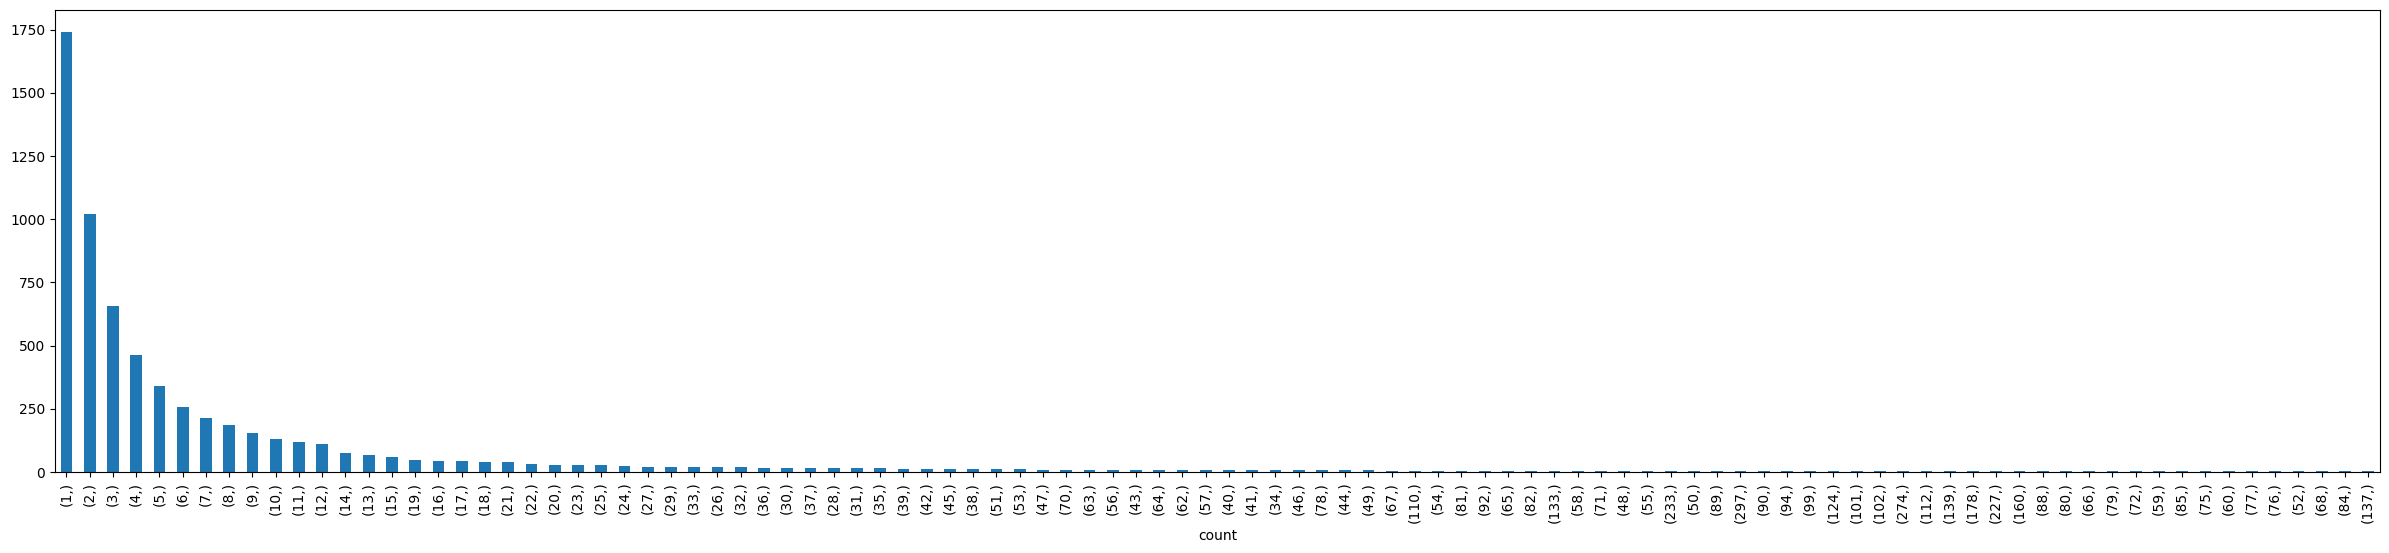

In [248]:
# Countplot of the frequency of the unique value frequencies in card1-test
plt.figure(figsize=(30,6))
test.card1.value_counts().to_frame().value_counts().head(100).plot.bar()

In [249]:
# identify and gather rare values in the 'card1' column in both the 'train' and 'test' DataFrames based on a frequency criterion. 
# After identifying these rare values, we collect them into a set (lower frequency means if a category has repeated lower than 3 in the column)
rareCards=[]
for k, df in enumerate([train, test]):
  rare_cards = df.card1.value_counts()
  rare_cards = rare_cards.where(rare_cards<3).dropna().sort_index().index # ==> rare_cards<3 refers to lower frequency
  rareCards += list(rare_cards)

  print(f"{('TEST' if k else 'TRAIN')}")
  print(f"Number of unique in card1: {df.card1.nunique()}")
  print(f"Number of unique values with frequency less than 3 in card1: {len(rare_cards)}\n")
rareCards = set(rareCards)

TRAIN
Number of unique in card1: 6675
Number of unique values with frequency less than 3 in card1: 1163

TEST
Number of unique in card1: 6675
Number of unique values with frequency less than 3 in card1: 2760



In [250]:
# We replaced "rare card1 values" with Nan. if a card repeated lower than 3
for df in [train, test]:
  df['card1'] = df['card1'].apply(lambda x: np.nan if x in rareCards else x)

Card2...Card6

In [251]:
# Same replacement for remaining card columns (card2-card6)
for col in ['card2','card3','card4','card5','card6']: 
  old_versions_col= set(train[col].unique()) - set(test[col].unique())
  new_versions_col = set(test[col].unique()) - set(train[col].unique()) 
  test[col] =test[col].apply(lambda x: np.nan if x in new_versions_col else x)
  train[col] =train[col].apply(lambda x: np.nan if x in old_versions_col else x)

In [252]:
rareCards = []

# Specify the range of columns you want to process
columns_to_process = [f'card{i}' for i in range(2, 7)]  # Assumes 'card2' to 'card6'

for col in columns_to_process:
    for k, df in enumerate([train, test]):
        rare_cards = df[col].value_counts()
        rare_cards = rare_cards.where(rare_cards < 3).dropna().sort_index().index
        rareCards += list(rare_cards)

        print(f"{('TEST' if k else 'TRAIN')}")
        print(f"Number of unique in {col}: {df[col].nunique()}")
        print(f"Number of unique values with frequency less than 3 in {col}: {len(rare_cards)}\n")

rareCards = set(rareCards)

TRAIN
Number of unique in card2: 495
Number of unique values with frequency less than 3 in card2: 0

TEST
Number of unique in card2: 495
Number of unique values with frequency less than 3 in card2: 1

TRAIN
Number of unique in card3: 70
Number of unique values with frequency less than 3 in card3: 5

TEST
Number of unique in card3: 70
Number of unique values with frequency less than 3 in card3: 17

TRAIN
Number of unique in card4: 4
Number of unique values with frequency less than 3 in card4: 0

TEST
Number of unique in card4: 4
Number of unique values with frequency less than 3 in card4: 0

TRAIN
Number of unique in card5: 66
Number of unique values with frequency less than 3 in card5: 6

TEST
Number of unique in card5: 66
Number of unique values with frequency less than 3 in card5: 8

TRAIN
Number of unique in card6: 2
Number of unique values with frequency less than 3 in card6: 0

TEST
Number of unique in card6: 2
Number of unique values with frequency less than 3 in card6: 0



In [253]:
# low frequency cats will change into nans
columns_to_process = [f'card{i}' for i in range(2, 7)]  # Assumes 'card2' to 'card6'

for col in columns_to_process:
    for df in [train, test]:
        df[col] = df[col].apply(lambda x: np.nan if x in rareCards else x)

One hot encoding is a common technique used to handle nominal categorical data by converting each category into a binary column. While label encoding can be suitable for ordinal categorical data, it's not the best choice for nominal categorical data due to its inherent ordering. Frequency encoding and target encoding provides an effective solution for nominal categorical data.
Because we have lots of distinct values in card1,2,3,5 columns(if we use target encoding most of the values will be too small near to 0 or will be 0) it is better to use frequency encoding by replacing each category with its observed frequency. We will use target encoder for card4(4 distinct values) and card6 (2 distinct values)

In [254]:
# List of columns to process (Number of unique values below 200) (taking into account the average of the target feature in train set)
columns_to_process = ['card3', 'card4', 'card5', 'card6']

# Loop through each column
for col in columns_to_process:
    # Calculate target encoding for the current column
    temp_dict = train.groupby([col])['isFraud'].agg(['mean']).to_dict()['mean']
    
    # Create a new column with the target encoding values
    train[f'{col}_target_encoded'] = train[col].replace(temp_dict)
    test[f'{col}_target_encoded'] = test[col].replace(temp_dict)

In [255]:
# Frequency encoding for card1 (Number of unique values above 200)
self_encode_False=['card1', 'card2']
train, test = frequency_encoding(train, test, self_encode_False, self_encoding=False)

In [256]:
# List of original columns to drop
columns_to_drop = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

# Drop the original columns
train.drop(columns_to_drop, axis=1, inplace=True)
test.drop(columns_to_drop, axis=1, inplace=True)


#### addr1 and addr2: Address information related to the transaction (nominal categorical)
Probably addr1 - subzone / add2 - Country

In [257]:
for df in [train, test]:
  column_details(regex='addr', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

addr1:  object, 321, %11.45
['100.0' '101.0' '102.0' '104.0' '105.0' '106.0' '110.0' '111.0' '112.0'
 '113.0' '117.0' '119.0' '120.0' '122.0' '123.0' '124.0' '125.0' '126.0'
 '127.0' '128.0' '129.0' '130.0' '131.0' '132.0' '133.0' '134.0' '137.0'
 '139.0' '141.0' '142.0' '143.0' '144.0' '145.0' '146.0' '148.0' '151.0'
 '152.0' '153.0' '154.0' '155.0' '156.0' '157.0' '158.0' '159.0' '160.0'
 '161.0' '162.0' '163.0' '164.0' '166.0' '167.0' '168.0' '170.0' '171.0'
 '172.0' '174.0' '177.0' '178.0' '180.0' '181.0' '182.0' '183.0' '184.0'
 '185.0' '187.0' '189.0' '190.0' '191.0' '193.0' '194.0' '195.0' '196.0'
 '198.0' '199.0' '200.0' '201.0' '202.0' '203.0' '204.0' '205.0' '208.0'
 '210.0' '211.0' '213.0' '214.0' '215.0' '216.0' '217.0' '218.0' '219.0'
 '220.0' '221.0' '223.0' '224.0' '225.0' '226.0' '227.0' '231.0' '232.0'
 '233.0' '234.0' '235.0' '236.0' '239.0' '241.0' '242.0' '243.0' '244.0'
 '247.0' '248.0' '249.0' '250

In [258]:
train.groupby('addr1')['isFraud'].mean().sort_values(ascending=False).head(20)

addr1
305.0    0.666667
466.0    0.500000
471.0    0.500000
483.0    0.500000
501.0    0.500000
391.0    0.457143
260.0    0.400000
431.0    0.342105
432.0    0.281250
296.0    0.233553
399.0    0.200000
239.0    0.200000
161.0    0.194774
216.0    0.180000
426.0    0.172414
453.0    0.166667
171.0    0.166667
199.0    0.125000
479.0    0.125000
356.0    0.123457
Name: isFraud, dtype: float64

In [259]:
# First ten most frequent adddress1 values in train
print ("Unique Subzones = ",train['addr1'].nunique())

print('\nFirst Ten Address-2')
print('--------------------')
train.addr1.value_counts().head(9)

Unique Subzones =  321

First Ten Address-2
--------------------


addr1
299.0    35042
325.0    31781
204.0    31261
264.0    29697
330.0    18576
315.0    17250
441.0    15527
272.0    15108
123.0    11935
Name: count, dtype: int64

In [260]:
train.groupby('addr2')['isFraud'].mean().sort_values(ascending=False).head(20)

addr2
10.0    1.000000
82.0    1.000000
46.0    1.000000
92.0    1.000000
75.0    1.000000
38.0    0.666667
65.0    0.581081
36.0    0.500000
73.0    0.200000
68.0    0.111111
96.0    0.107011
60.0    0.096003
29.0    0.090909
32.0    0.072289
87.0    0.024207
84.0    0.000000
88.0    0.000000
59.0    0.000000
61.0    0.000000
62.0    0.000000
Name: isFraud, dtype: float64

In [261]:
print ("Unique Countries = ",train['addr2'].nunique())

print('\nFirst Ten Address-2')
print('--------------------')
train.addr2.value_counts().head(9)

Unique Countries =  69

First Ten Address-2
--------------------


addr2
87.0    388434
60.0      2677
96.0       542
32.0        83
65.0        74
16.0        48
31.0        45
19.0        29
26.0        20
Name: count, dtype: int64

In [262]:
# By combining addr1 and addr2 , we create a new addr column
for df in [train, test]:
    # Combine 'addr2' and 'addr1' columns as strings, separated by an underscore
    df['addr'] = (df['addr2'].astype(str) + '_' + df['addr1'].astype(str)).replace({'nan_nan': np.nan})

In [263]:
train.groupby('addr')['isFraud'].mean().sort_values(ascending=False).head(20)

addr
10.0_296.0    1.000000
46.0_296.0    1.000000
60.0_296.0    1.000000
92.0_296.0    1.000000
82.0_296.0    1.000000
75.0_296.0    1.000000
65.0_296.0    0.704918
38.0_296.0    0.666667
60.0_305.0    0.666667
36.0_296.0    0.500000
60.0_466.0    0.500000
60.0_471.0    0.500000
60.0_501.0    0.500000
60.0_483.0    0.500000
60.0_391.0    0.457143
87.0_260.0    0.400000
60.0_431.0    0.342105
96.0_432.0    0.281250
73.0_296.0    0.250000
60.0_239.0    0.200000
Name: isFraud, dtype: float64

In [264]:
print ("Unique Adresses = ",train['addr'].nunique())

print('\nFirst Ten Addresses')
print('--------------------')
train.addr.value_counts().head(9)

Unique Adresses =  409

First Ten Addresses
--------------------


addr
87.0_299.0    35033
87.0_325.0    31780
87.0_204.0    31260
87.0_264.0    29697
87.0_330.0    18573
87.0_315.0    17249
87.0_441.0    15525
87.0_272.0    15107
87.0_123.0    11933
Name: count, dtype: int64

In [265]:
# unique values for address columns in train
train['addr1'].nunique(), train['addr2'].nunique(), train['addr'].nunique()

(321, 69, 409)

In [266]:
# unique values for address columns in train
test['addr1'].nunique(), test['addr2'].nunique(), test['addr'].nunique()

(116, 28, 147)

In [267]:
# Frequency encoding for addr columns
self_encode_False=['addr']
train, test = frequency_encoding(train, test, self_encode_False, self_encoding=False)

self_encode_False=['addr1']
train, test = frequency_encoding(train, test, self_encode_False, self_encoding=False)

self_encode_False=['addr2']
train, test = frequency_encoding(train, test, self_encode_False, self_encoding=False)

In [268]:
# List of original columns to drop
columns_to_drop = ['addr', 'addr1', 'addr2']

# Drop the original columns
train.drop(columns_to_drop, axis=1, inplace=True)
test.drop(columns_to_drop, axis=1, inplace=True)

**Top 'addr1' Values by Fraud Rate:**
The 'addr1' values with the highest fraud rates are 305.0, 466.0, 471.0, 483.0, and 501.0.
For example, transactions with 'addr1' equal to 305.0 have a fraud rate of 66.67%.

**Top 'addr2' Values by Fraud Rate:**
The 'addr2' values with the highest fraud rates are 10.0, 82.0, 46.0, 92.0, and 75.0.
For example, transactions with 'addr2' equal to 10.0 have a fraud rate of 100%.

**Top Combined 'addr' Values by Fraud Rate:**
The combined 'addr' values (created by concatenating 'addr2' and 'addr1') with the highest fraud rates are 10.0_296.0, 46.0_296.0, 60.0_296.0, 92.0_296.0, and 82.0_296.0.
For example, transactions with 'addr' equal to 10.0_296.0 have a fraud rate of 100%.

**Insights:**
Certain combinations of 'addr1' and 'addr2' or the combined 'addr' exhibit higher fraud rates. For instance, the combination 10.0_296.0 appears to have a consistent fraud rate of 100% across 'addr1' and 'addr2'.
These patterns may indicate potential areas of interest for further investigation or feature engineering. High fraud rates in specific 'addr' combinations could be indicative of fraudulent behavior or anomalies in those locations.

#### dist1 : The distance (numeric)

In [269]:
column_details(regex='^dist', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

dist1:  float64, 1744, %54.87
[0.000e+00 1.000e+00 2.000e+00 ... 7.136e+03 8.081e+03       nan]



Text(0.5, 1.0, 'Test')

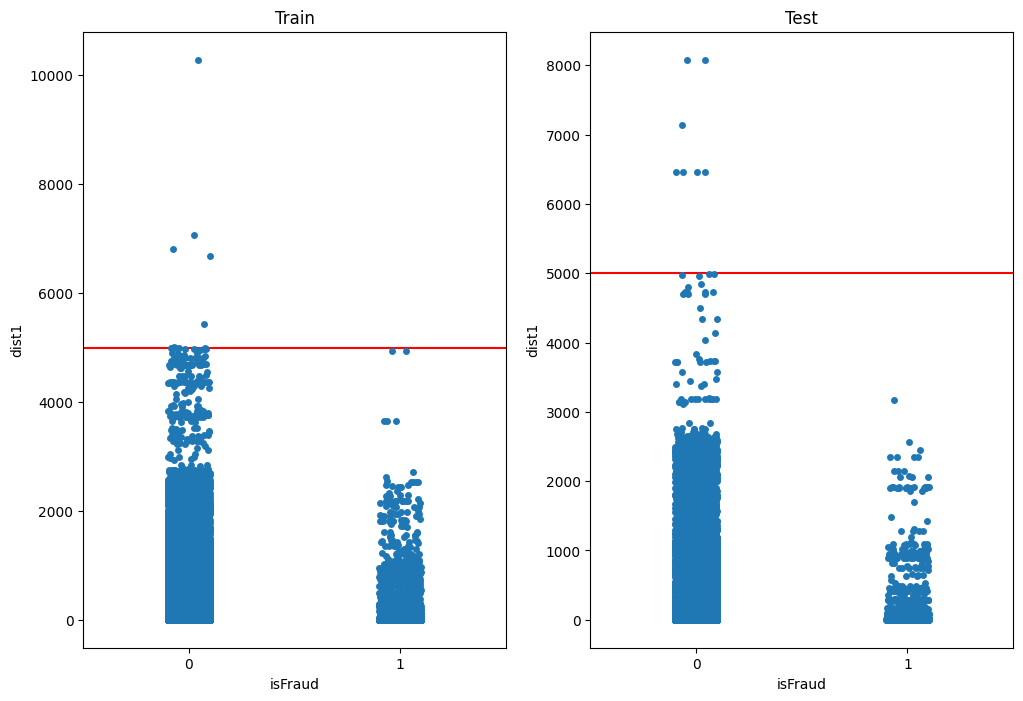

In [270]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='dist1', x='isFraud', data=train)
plt.axhline(5000, color='red')
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='dist1', x='isFraud', data=test)
plt.axhline(5000, color='red')
plt.title('Test')

In [271]:
max_dist1 = train['dist1'][train['dist1'] < 5500].max()
print(f"The maximum dist1 below 5500 is: {max_dist1}")


The maximum dist1 below 5500 is: 5431.0


There are outliers in dist1 with isFraud == 0. These are above 5500. 
We find the maximum amount below 5500 ( 5431 ). We will capped the Train with 5432 below code.

In [272]:
# Identify transactions with isFraud == 0 and dist1 5431
condition = train['dist1'] > 5431

# Cap the dist1 at 5432 for the identified transactions
train.loc[condition, 'dist1'] = 5431

In [273]:
train['dist1'].max()

5431.0

#### P_emaildomain&R_emaildomain

P_emaildomain : categoric, 56 uniques
It's possible to make subgroup feature from it or general group


R_emaildomain : categoric, 59 uniques
It's possible to make subgroup feature from it or general group

In [274]:
# R_emaildomain
column_details(regex='R_emaildomain', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

R_emaildomain:  object, 60, %75.56
['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'msn.com' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'scranton.edu' 'servicios-ta.com' 'suddenlink.net' 'twc.com'
 'verizon.net' 'web.de' 'windstream.net' 'yahoo.co.jp' 'yahoo.co.uk'
 'yahoo.com' 'yahoo.com.mx' 'yahoo.de' 'yahoo.es' 'yahoo.fr' 'ymail.com'
 nan]



In [275]:
#We produced 2 new columns with mail server and domain for R_emaildomain.
for df in [train, test]:
  df['R_emaildomain_1'] = df['R_emaildomain'].fillna('').apply(lambda x: x.split(".")[0]).replace({'':np.nan})
  df['R_emaildomain_2'] = df['R_emaildomain'].str.split('.', expand=True).iloc[:,1:].fillna('').apply(lambda x:('.'.join(x)).strip('.'), axis=1).replace({'':np.nan})

In [276]:
# P_emaildomain
column_details(regex='P_emaildomain', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

P_emaildomain:  object, 59, %15.55
['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'msn.com' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'servicios-ta.com' 'suddenlink.net' 'twc.com' 'verizon.net' 'web.de'
 'windstream.net' 'yahoo.co.jp' 'yahoo.co.uk' 'yahoo.com' 'yahoo.com.mx'
 'yahoo.de' 'yahoo.es' 'yahoo.fr' 'ymail.com' nan]



In [277]:
# We produced 2 new columns with mail server and domain P_emaildomain.
for df in [train, test]:
  df['P_emaildomain_1'] = df['P_emaildomain'].fillna('').apply(lambda x: x.split(".")[0]).replace({'':np.nan})
  df['P_emaildomain_2'] = df['P_emaildomain'].str.split('.', expand=True).iloc[:,1:].fillna('').apply(lambda x:('.'.join(x)).strip('.'), axis=1).replace({'':np.nan})

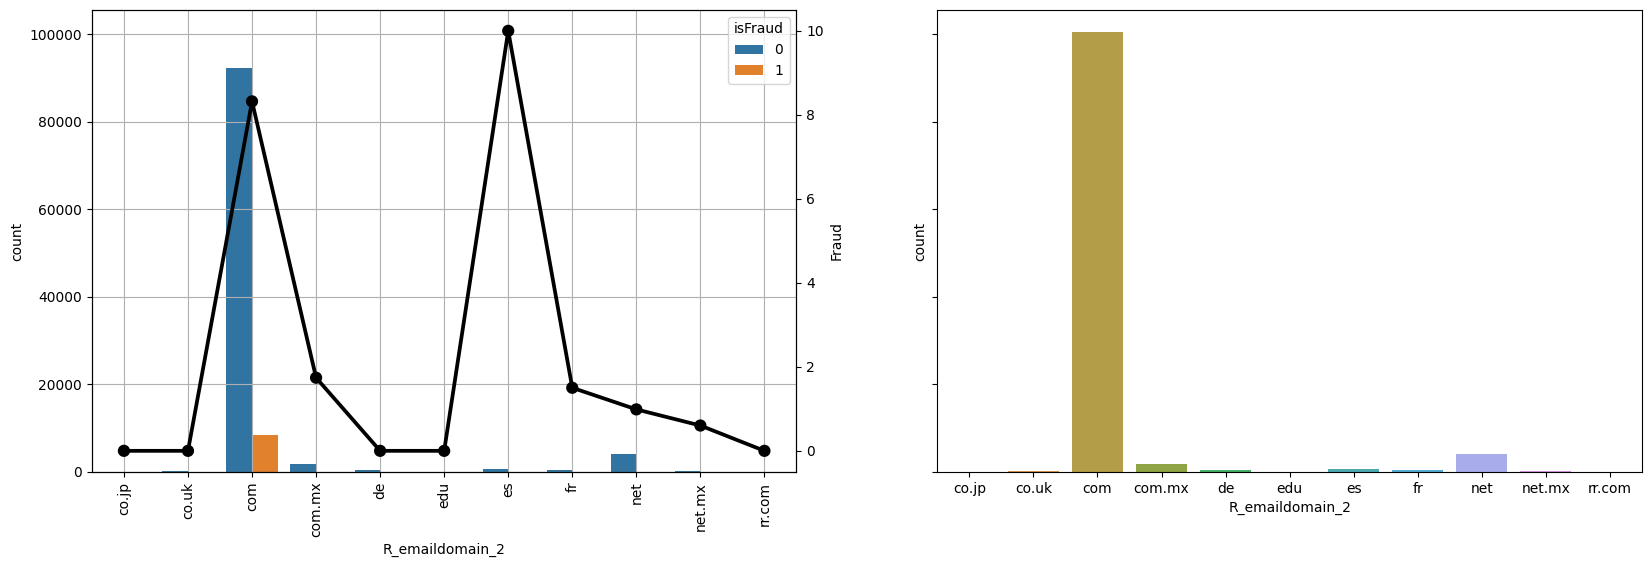

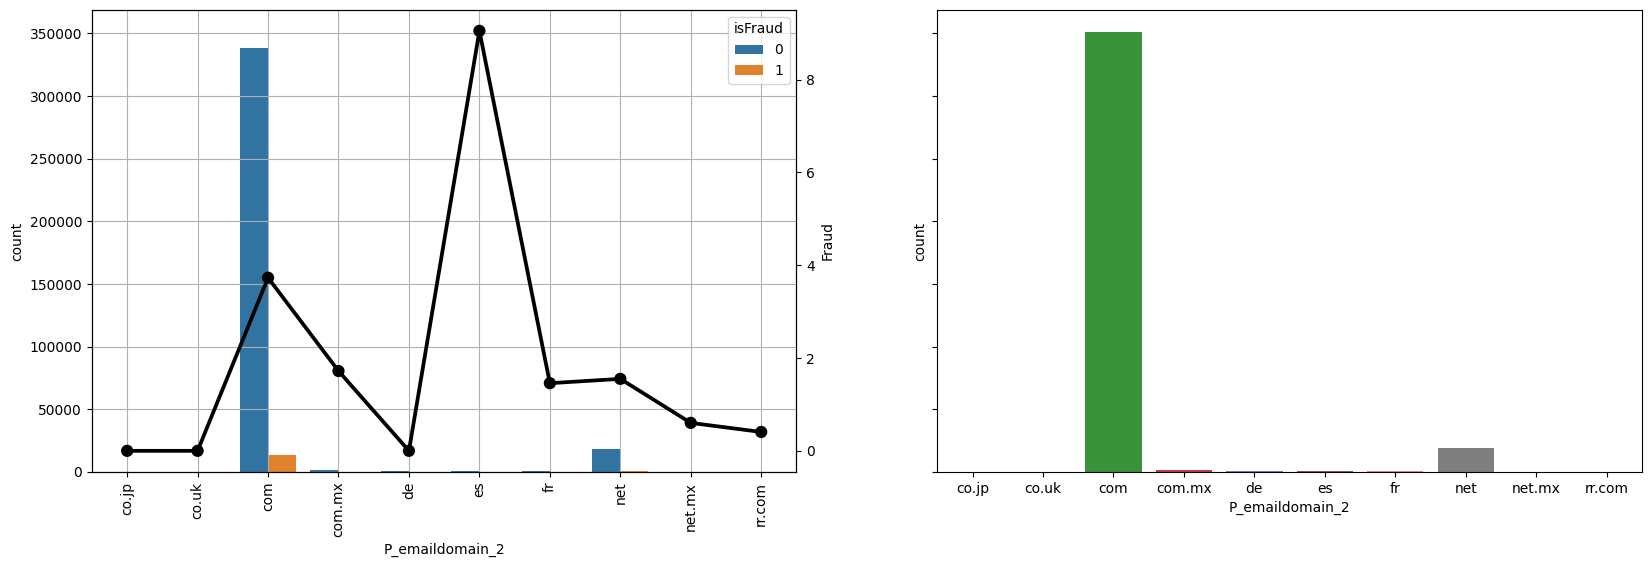

In [278]:
for col in ['R_emaildomain_2', 'P_emaildomain_2']:
  plot_col(col, df=train)

In [279]:
# es has 10% fraud rate
fraud_rates = train.groupby('R_emaildomain_2')['isFraud'].mean().reset_index()
fraud_rates.rename(columns={'isFraud': 'FraudRate'}, inplace=True)
fraud_rates.sort_values(by='FraudRate', ascending=False).head()

R_emaildomain_2  FraudRate
6              es   0.100000
2             com   0.083204
3          com.mx   0.017406
7              fr   0.015015
8             net   0.009868

Two highest fraud activity domains:
* es (Spain) Category: The category associated with Spain (es) has a higher fraud rate compared to other categories (%10). This suggests that transactions originating from Spain may require closer scrutiny in terms of fraud detection.

* com (United States) Category: The category associated with the United States (com) has a significantly higher fraud rate compared to other categories (%8.32). This may imply the need for careful examination of transactions coming from this geographical region.

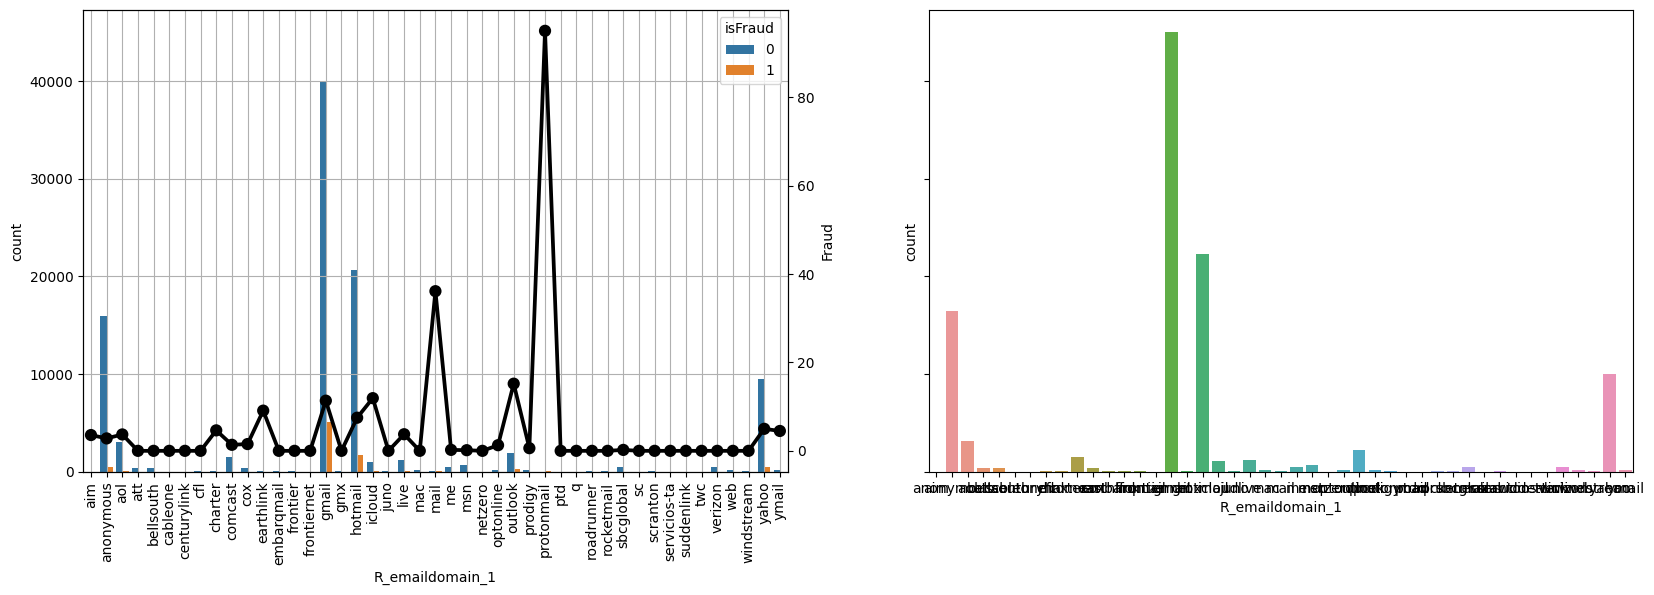

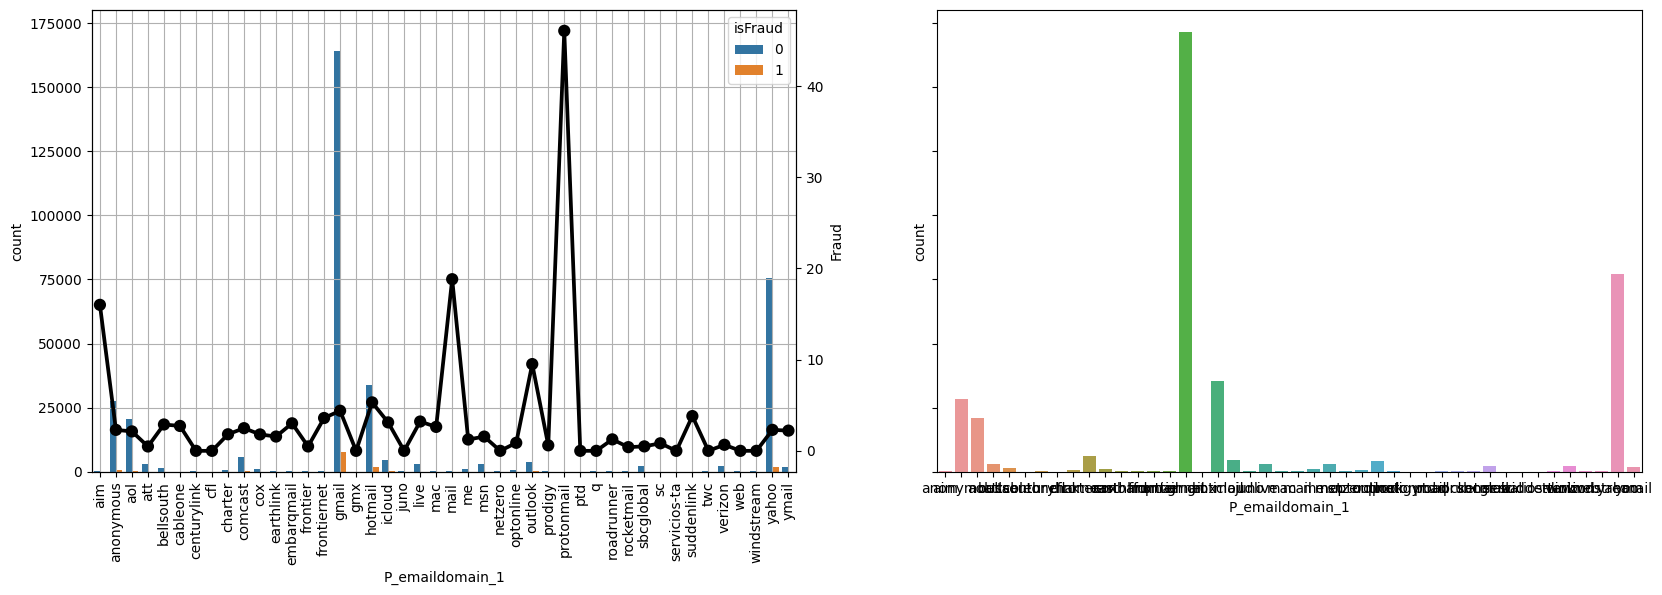

In [280]:
for col in ['R_emaildomain_1', 'P_emaildomain_1']:
  plot_col(col, df=train)

In [281]:
# Protonmail has 95% fraud rate
fraud_rates = train.groupby('R_emaildomain_1')['isFraud'].mean().reset_index()
fraud_rates.rename(columns={'isFraud': 'FraudRate'}, inplace=True)
fraud_rates.sort_values(by='FraudRate', ascending=False).head()

R_emaildomain_1  FraudRate
29      protonmail   0.950000
22            mail   0.361111
27         outlook   0.151882
18          icloud   0.119157
15           gmail   0.113450

Two highest fraud activity domains:

* ProtonMail Category: The ProtonMail category has a significantly higher fraud rate compared to other categories (%95). This indicates that transactions originating from ProtonMail may pose a higher risk of fraud. Careful scrutiny of transactions associated with such accounts could be crucial.

* Mail Category: This general 'mail' category exhibits a higher fraud rate compared to other categories (%36). This suggests that transactions from general email providers should be examined with caution.

In [282]:
# correlation between R_emaildomain_2 and P_emaildomain_2 - train
cramers_v(train.R_emaildomain_2,train.P_emaildomain_2)

0.8926752413893435

In [283]:
# correlation between R_emaildomain_2 and P_emaildomain_2 - test
cramers_v(test.R_emaildomain_2,test.P_emaildomain_2)

0.8813311624433039

In [284]:
# correlation between R_emaildomain_1 and P_emaildomain_1 - train
cramers_v(train.R_emaildomain_1,train.P_emaildomain_1)

0.6060523585208291

In [285]:
# correlation between R_emaildomain_1 and P_emaildomain_1 - test
cramers_v(test.R_emaildomain_1,test.P_emaildomain_1)

0.5873334446544154

In [286]:
# R_emaildomain_2 and P_emaildomain_2 are categorically 90% correlated. So we dropped P_emaildomain_2. (Try vice versa later)
# R_emaildomain_1, P_emaildomain_1, R_emaildomain_2 are staying
train = train.drop(['R_emaildomain','P_emaildomain','P_emaildomain_2'], axis=1)
test = test.drop(['R_emaildomain','P_emaildomain','P_emaildomain_2'], axis=1)

In [287]:
# Target Encoding For R_emaildomain_1, P_emaildomain_1, R_emaildomain_2 (taking into account the average of the target feature in train set)
temp_dict = train.groupby(['R_emaildomain_1'])['isFraud'].agg(['mean']).to_dict()['mean']
train['R_emaildomain_1_target_encoded'] = train['R_emaildomain_1'].replace(temp_dict)
test['R_emaildomain_1_target_encoded']  = test['R_emaildomain_1'].replace(temp_dict)


temp_dict = train.groupby(['P_emaildomain_1'])['isFraud'].agg(['mean']).to_dict()['mean']
train['P_emaildomain_1_target_encoded'] = train['P_emaildomain_1'].replace(temp_dict)
test['P_emaildomain_1_target_encoded']  = test['P_emaildomain_1'].replace(temp_dict)

temp_dict = train.groupby(['R_emaildomain_2'])['isFraud'].agg(['mean']).to_dict()['mean']
train['R_emaildomain_2_target_encoded'] = train['R_emaildomain_2'].replace(temp_dict)
test['R_emaildomain_2_target_encoded']  = test['R_emaildomain_2'].replace(temp_dict)

In [288]:
# List of original columns to drop
columns_to_drop = ['R_emaildomain_1', 'R_emaildomain_2', 'P_emaildomain_1']

# Drop the original columns
train.drop(columns_to_drop, axis=1, inplace=True)
test.drop(columns_to_drop, axis=1, inplace=True)

#### C1 .... C14 : Counting variables such as how many addresses are found to be associated with the payment card (numeric)

In [289]:
column_details(regex='^C\d', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

C1:  float64, 1577, %0.0
[0.000e+00 1.000e+00 2.000e+00 ... 4.682e+03 4.684e+03 4.685e+03]

C2:  float64, 1078, %0.0
[0.000e+00 1.000e+00 2.000e+00 ... 5.625e+03 5.690e+03 5.691e+03]

C4:  float64, 1214, %0.0
[0.000e+00 1.000e+00 2.000e+00 ... 2.251e+03 2.252e+03 2.253e+03]

C5:  float64, 309, %0.0
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.

In [290]:
# Finding highly correlated columns to drop
columns=[col for col in train.columns if re.search('^C\d.*', col)]
corr_treshold = 0.75
drop_col = remove_collinear_features(train[columns],corr_treshold)
drop_col

{'C1', 'C10', 'C11', 'C12', 'C14', 'C2', 'C4', 'C6', 'C7', 'C8', 'C9'}

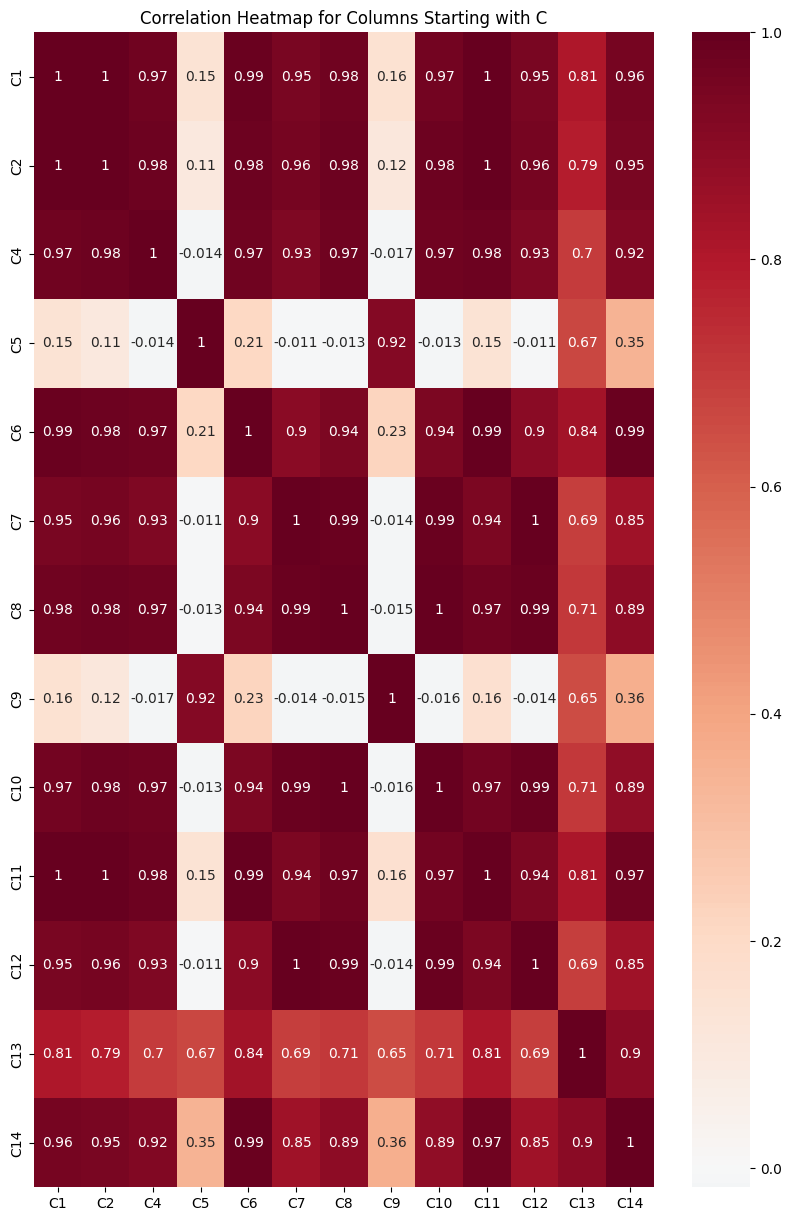

In [291]:
# Select columns starting with 'C'
columns = [col for col in train.columns if re.search('^C\d.*', col)]

# Create a correlation heatmap using the make_corr function
make_corr(columns, train)


In [292]:
# Only C1 and C5 remained.
train = train.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)

In [293]:
'''
# NO outlier for C1 column
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='C1', x='isFraud', data=train)
plt.axhline(5000, color='red')
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='C1', x='isFraud', data=test)
plt.axhline(5000, color='red')
plt.title('Test')
'''

"\n# NO outlier for C1 column\nplt.figure(figsize=(12,8))\nplt.subplot(121)\nsns.stripplot(y='C1', x='isFraud', data=train)\nplt.axhline(5000, color='red')\nplt.title('Train')\n\nplt.subplot(122)\nsns.stripplot(y='C1', x='isFraud', data=test)\nplt.axhline(5000, color='red')\nplt.title('Test')\n"

Text(0.5, 1.0, 'Test')

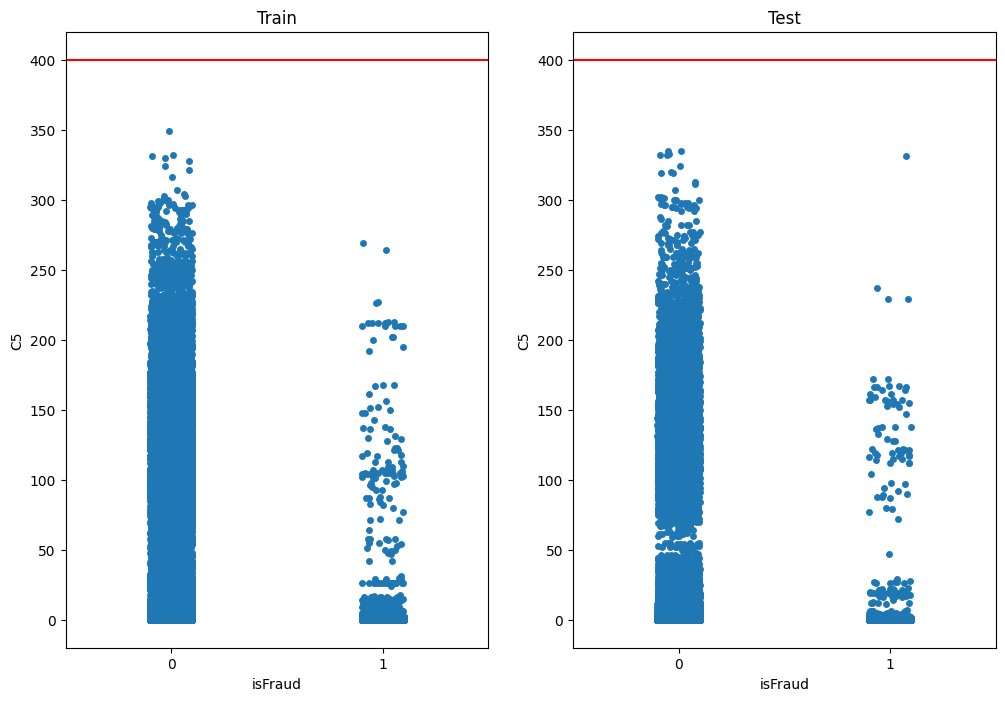

In [294]:
# NO outlier for C5 column
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='C5', x='isFraud', data=train)
plt.axhline(400, color='red')
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='C5', x='isFraud', data=test)
plt.axhline(400, color='red')
plt.title('Test')

#### D1...D15 : Timedelta variables, such as days between previous transaction (numeric)

In [295]:
for df in [train, test]:
  column_details(regex='^D\d.*', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

D1:  float64, 641, %0.06
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 

In [296]:
columns=[col for col in train.columns if re.search('^D\d.*', col)]

corr_treshold = 0.75
drop_col = remove_collinear_features(train[columns],corr_treshold)
drop_col

{'D11', 'D12', 'D2', 'D4'}

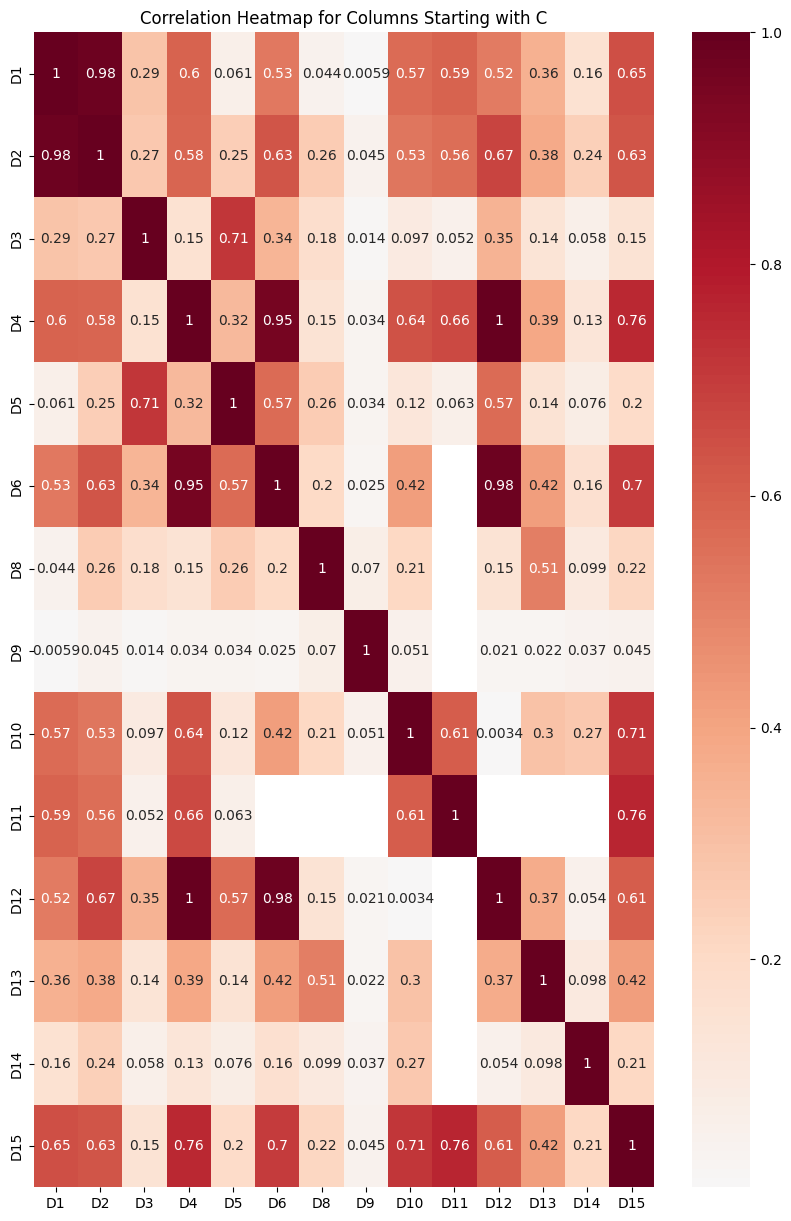

In [297]:
# Create a correlation heatmap using the make_corr function
make_corr(columns, train)

In [298]:
# The correlated columns having the most missing values are dropped. So, we replaced some columns in the dropping column list below.
drop_col={'D11', 'D12', 'D2', 'D4'}
for df in [train, test]:
  df = df.drop(drop_col, axis=1)

#### M1 ... M9 : Match variables, used to verify information such as names on the card and address. (nominal categoric)

In [299]:
column_details(regex='^M\d*', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

M1:  object, 2, %51.88
['F' 'T' nan]

M2:  object, 2, %51.88
['F' 'T' nan]

M3:  object, 2, %51.88
['F' 'T' nan]

M4:  object, 3, %48.26
['M0' 'M1' 'M2' nan]

M5:  object, 2, %60.23
['F' 'T' nan]

M6:  object, 2, %30.45
['F' 'T' nan]

M7:  object, 2, %64.81
['F' 'T' nan]

M8:  object, 2, %64.8
['F' 'T' nan]

M9:  object, 2, %64.8
['F' 'T' nan]



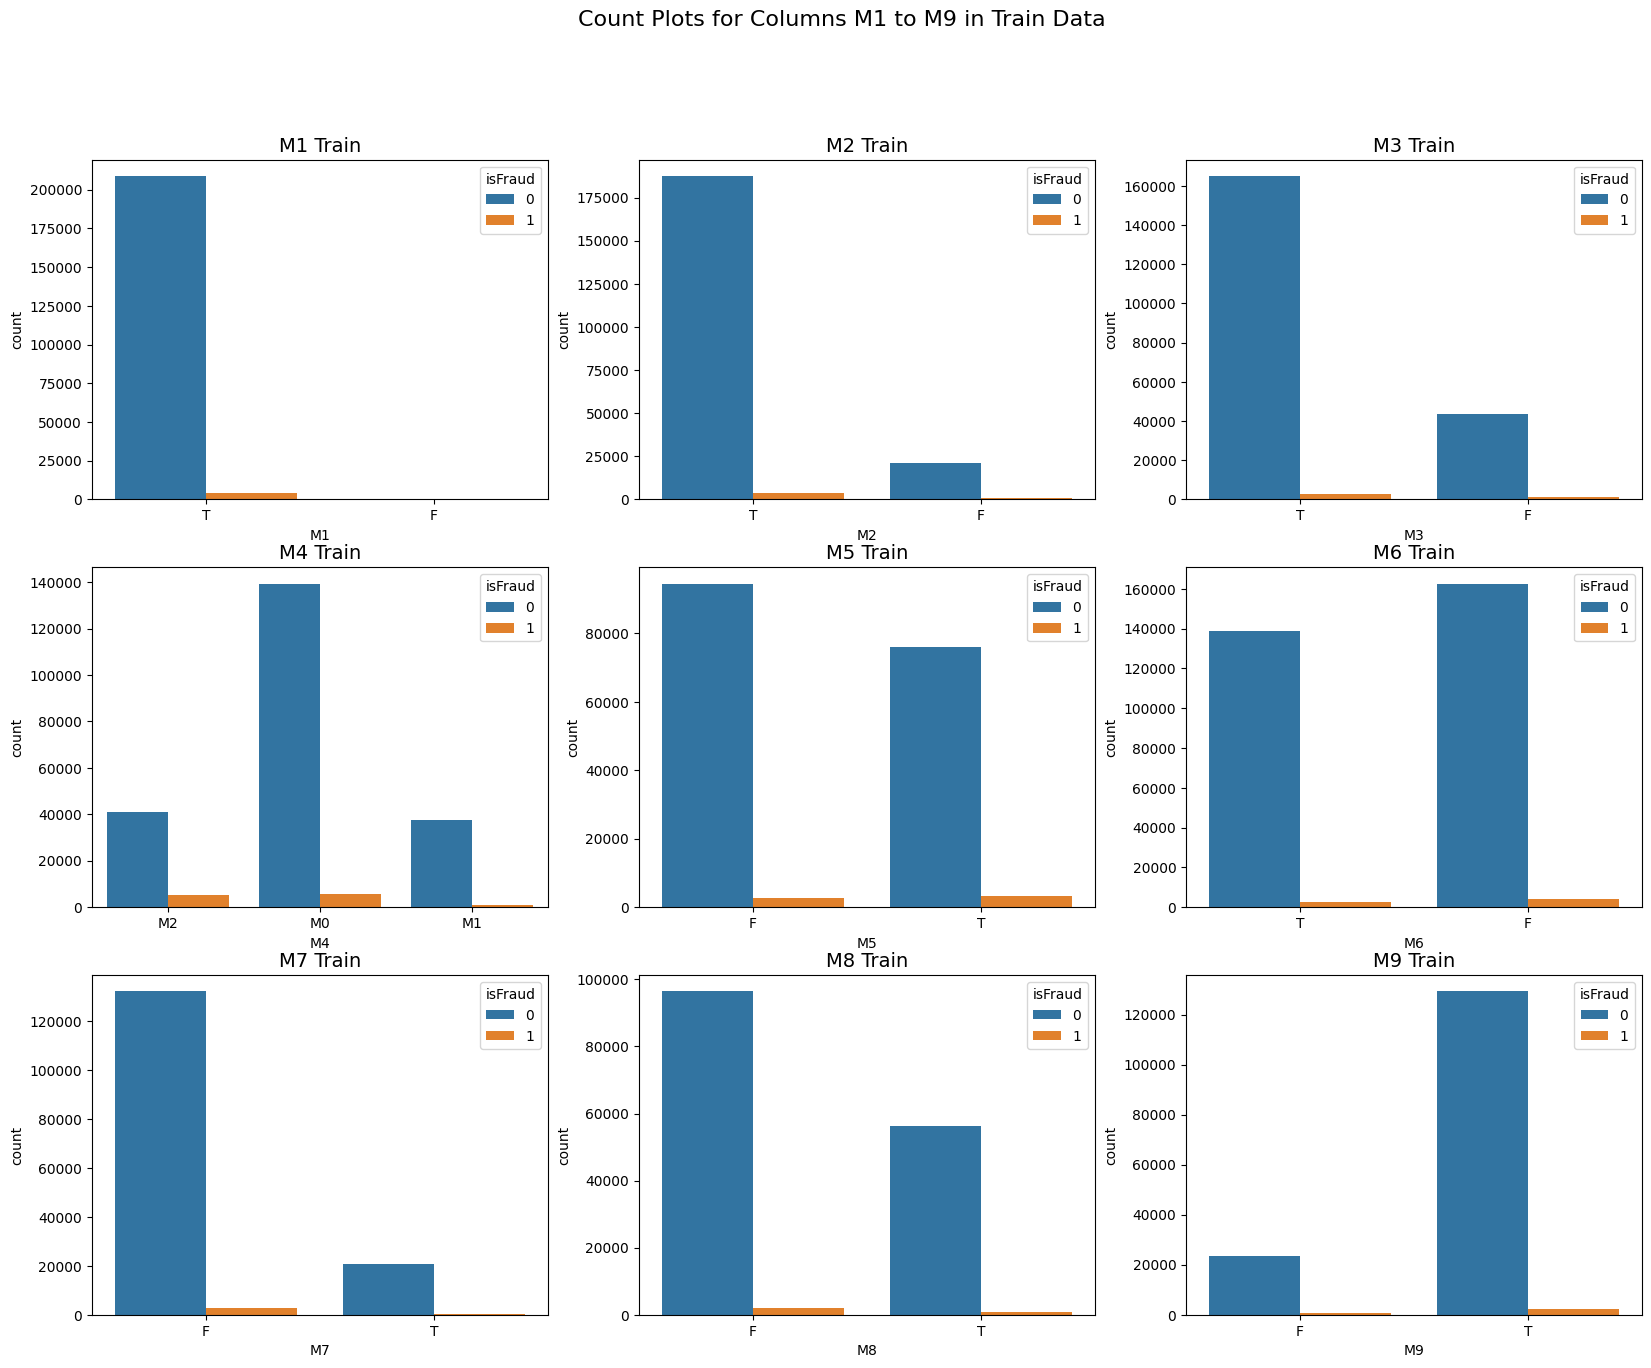

In [300]:
# Just M4 has different categories, others have F,T,nan
fig, ax = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Count Plots for Columns M1 to M9 in Train Data', fontsize=16)

for i, col in enumerate(['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']):
    row_num = i // 3
    col_num = i % 3
    sns.countplot(x=col, ax=ax[row_num, col_num], hue='isFraud', data=train)
    ax[row_num, col_num].set_title(f'{col} Train', fontsize=14)


In [301]:
# Target Encoding for M columns
# Define the list of columns from 'M1' to 'M9'
m_columns = [f'M{i}' for i in range(1, 10)]

# Calculate and replace target mean for each column
for col in m_columns:
    temp_dict = train.groupby([col])['isFraud'].agg(['mean']).to_dict()['mean']
    train[col+'_target_encoded'] = train[col].replace(temp_dict)
    test[col+'_target_encoded'] = test[col].replace(temp_dict)


In [302]:
# List of original columns to drop
columns_to_drop = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

# Drop the original columns
train.drop(columns_to_drop, axis=1, inplace=True)
test.drop(columns_to_drop, axis=1, inplace=True)

#### V1-V339 : Vesta-engineered features that encompass ranking, counting, and various entity relationships.(numeric)

We identified redundancy and correlation among the 'V' columns, and dropped correlated columns with a correlation coefficient (r) greater than 0.75. This process resulted in retaining only 69 independent 'V' columns.

In [303]:
column_details(regex='V\d*', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

V1:  float32, 2, %30.12
[ 0.  1. nan]

V2:  float32, 9, %30.12
[ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]

V3:  float32, 10, %30.12
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]

V4:  float32, 7, %30.12
[ 0.  1.  2.  3.  4.  5.  6. nan]

V5:  float32, 7, %30.12
[ 0.  1.  2.  3.  4.  5.  6. nan]

V6:  float32, 10, %30.12
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]

V7:  float32, 10, %30.12
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]

V8:  float32, 9, %30.12
[ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]

V9:  float32, 9, %30.12
[ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]

V10:  float32, 5, %30.12
[ 0.  1.  2.  3.  4. nan]

V11:  float32, 6, %30.12
[ 0.  1.  2.  3.  4.  5. nan]

V12:  float32, 4, %8.45
[ 0.  1.  2.  3. nan]

V13:  float32, 7, %8.45
[ 0.  1.  2.  3.  4.  5.  6. nan]

V14:  float32, 2, %8.45
[ 0.  1. nan]

V15:  float32, 3, %8.45
[ 0.  1.  2. nan]

V16:  float32, 5, %8.45
[ 0.  1.  2.  3.  4. nan]

V17:  float3

In [304]:
# removing high correlated variables (222 eliminated)
corr_treshold = 0.75
drop_col = remove_collinear_features(train[columns],corr_treshold)
len(drop_col)

222

In [305]:
# dropping redundant Vs
train = train.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)

In [306]:
# remaining Vs lenght (64 vars)
columns=[col for col in train.columns if re.search('^V\d*', col)]
len(columns)

64

<Axes: >

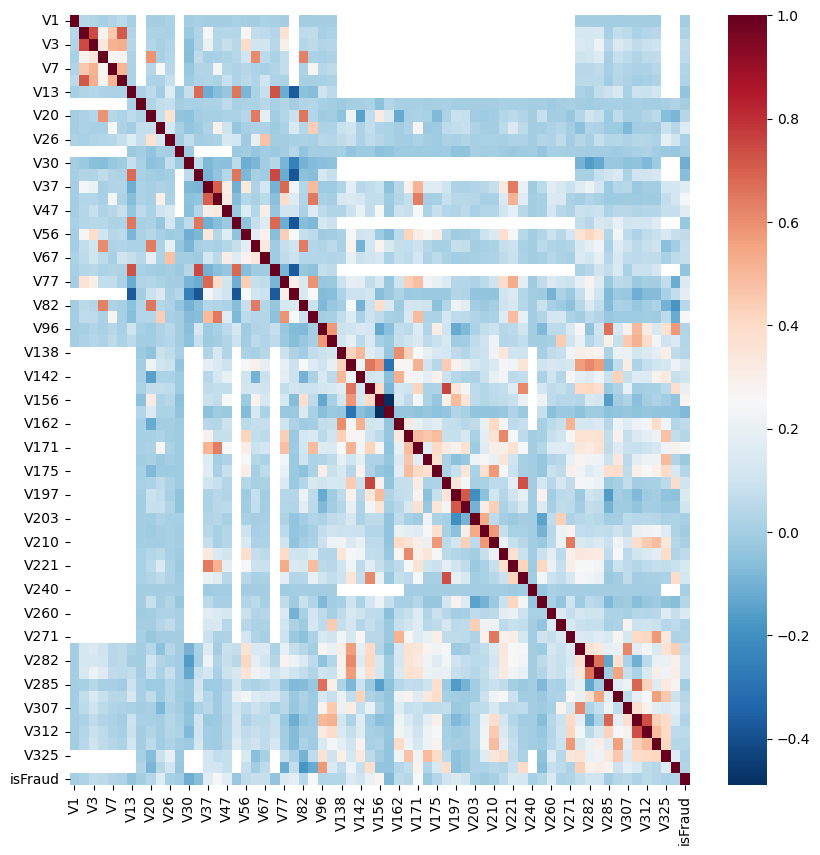

In [307]:
plt.figure(figsize=(10,10))
sns.heatmap(train[columns+['isFraud']].sample(frac=0.2).corr(),annot=False, cmap="RdBu_r")

In [308]:
#pickling datasets
#Save 'train' data to a pickle file named 'train_2.pkl'
train.to_pickle(r'../dataset/train_2.pkl')

#save 'test' data to a pickle file named 'test_2.pkl'
test.to_pickle(r'../dataset/test_2.pkl')


In [309]:
# Read the 'train_2.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('../dataset/train_2.pkl')

# Read the 'test_2.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('../dataset/test_2.pkl')

#### id_1 ... id_11 (numeric)

In [310]:
column_details(regex='id_(1|2|3|4|5|6|7|8|9|10|11)$', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

id_10:  float64, 59, %86.74
[-100.  -68.  -64.  -60.  -59.  -58.  -57.  -56.  -55.  -54.  -51.  -50.
  -49.  -47.  -44.  -43.  -42.  -41.  -40.  -39.  -38.  -37.  -36.  -35.
  -34.  -33.  -32.  -31.  -30.  -29.  -28.  -27.  -26.  -25.  -24.  -23.
  -22.  -21.  -20.  -19.  -18.  -17.  -16.  -15.  -14.  -13.  -12.  -11.
  -10.   -9.   -8.   -7.   -6.   -5.   -4.   -3.   -2.   -1.    0.   nan]

id_11:  float64, 346, %74.59
[ 90.          90.09999847  90.11000061  90.16000366  90.19999695
  90.20999908  90.23999786  90.26999664  90.27999878  90.29000092
  90.31999969  90.34999847  90.36000061  90.37999725  90.41000366
  90.43000031  90.48000336  90.51999664  90.52999878  90.54000092
  90.55000305  90.56999969  90.58999634  90.62999725  90.65000153
  90.69999695  90.73999786  90.76999664  90.80000305  90.83000183
  90.84999847  90.91000366  91.          91.02999878  91.06999969
  91.08999634  91.11000061  91.13999939  91.150

In [311]:
# removing high correlated variables 
corr_treshold = 0.75
drop_col = remove_collinear_features(train[columns],corr_treshold)
len(drop_col)

0

<Axes: >

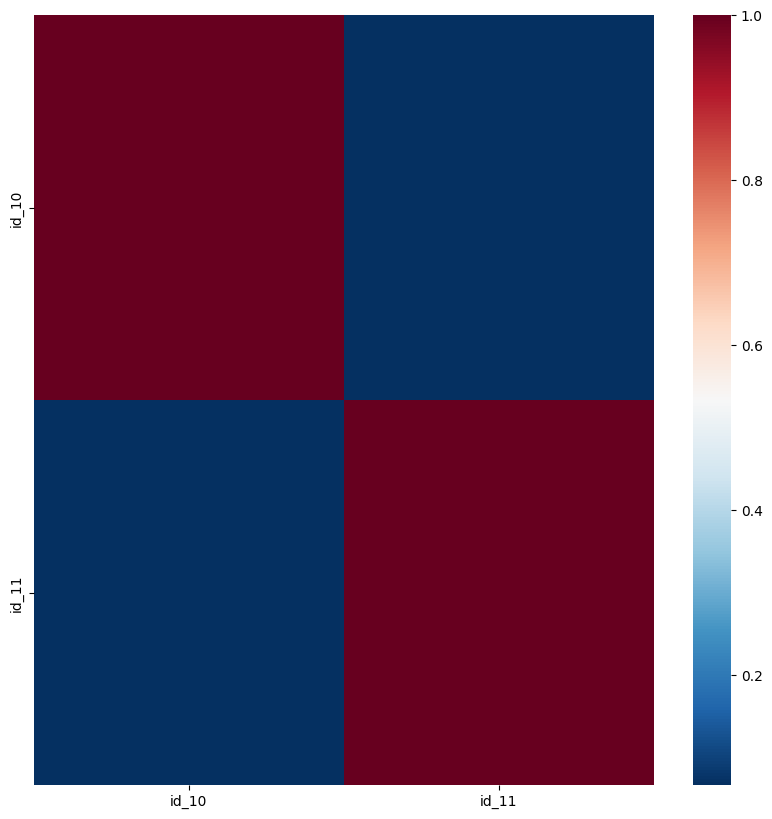

In [312]:
plt.figure(figsize=(10,10))
sns.heatmap(train[columns].sample(frac=0.2).corr(),annot=False, cmap="RdBu_r")

There is no correlation between these two variables, we are remaining them.

#### id_12...id_38 (nominal categoric)

In [313]:
column_details(regex='id_(12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38)', df=train)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

id_12:  object, 2, %74.02
['Found' 'NotFound' nan]

id_13:  object, 52, %77.38
['10.0' '11.0' '12.0' '13.0' '14.0' '15.0' '17.0' '18.0' '19.0' '20.0'
 '21.0' '22.0' '23.0' '24.0' '25.0' '26.0' '28.0' '29.0' '30.0' '31.0'
 '32.0' '33.0' '34.0' '35.0' '36.0' '37.0' '38.0' '39.0' '40.0' '41.0'
 '43.0' '44.0' '45.0' '46.0' '47.0' '48.0' '49.0' '50.0' '51.0' '52.0'
 '53.0' '54.0' '55.0' '56.0' '57.0' '58.0' '59.0' '60.0' '61.0' '62.0'
 '63.0' '64.0' nan]

id_14:  object, 25, %85.14
['-120.0' '-180.0' '-210.0' '-240.0' '-300.0' '-360.0' '-420.0' '-480.0'
 '-540.0' '-600.0' '-660.0' '0.0' '120.0' '180.0' '240.0' '270.0' '300.0'
 '330.0' '360.0' '420.0' '480.0' '540.0' '60.0' '600.0' '720.0' nan]

id_15:  object, 3, %74.59
['Found' 'New' 'Unknown' nan]

id_16:  object, 2, %76.65
['Found' 'NotFound' nan]

id_17:  object, 101, %74.83
['100.0' '101.0' '102.0' '105.0' '106.0' '107.0' '110.0' '111.0' '112.0'
 '114.0' '116.0' '117.0'

In [314]:
# Syncronize train and test
for col in [ 'id_12', 'id_13', 'id_14','id_15', 'id_17', 'id_19', 'id_30', 'id_31', 'id_32', 'id_34', 'id_36', 'id_37', 'id_38']: 
  old_versions_col= set(train[col].unique()) - set(test[col].unique())
  new_versions_col = set(test[col].unique()) - set(train[col].unique()) 
  test[col] =test[col].apply(lambda x: np.nan if x in new_versions_col else x)
  train[col] =train[col].apply(lambda x: np.nan if x in old_versions_col else x)

In [315]:
rareIds = []

# Specify the range of columns you want to process
columns_to_process = ['id_12', 'id_13', 'id_14',
           'id_15', 'id_17', 'id_19', 'id_30', 'id_31', 'id_32', 'id_34', 'id_36', 'id_37', 'id_38']

for col in columns_to_process:
    for k, df in enumerate([train, test]):
        rareIds = df[col].value_counts()
        rareIds = [value for value in rareIds.index if rareIds[value] < 3]
        rareIds += rareIds

        print(f"{('TEST' if k else 'TRAIN')}")
        print(f"Number of unique in {col}: {df[col].nunique()}")
        print(f"Number of unique values with frequency less than 3 in {col}: {len(rareIds)}\n")

rareIds = set(rareIds)


TRAIN
Number of unique in id_12: 2
Number of unique values with frequency less than 3 in id_12: 0

TEST
Number of unique in id_12: 2
Number of unique values with frequency less than 3 in id_12: 0

TRAIN
Number of unique in id_13: 19
Number of unique values with frequency less than 3 in id_13: 2

TEST
Number of unique in id_13: 19
Number of unique values with frequency less than 3 in id_13: 2

TRAIN
Number of unique in id_14: 18
Number of unique values with frequency less than 3 in id_14: 0

TEST
Number of unique in id_14: 18
Number of unique values with frequency less than 3 in id_14: 4

TRAIN
Number of unique in id_15: 3
Number of unique values with frequency less than 3 in id_15: 0

TEST
Number of unique in id_15: 3
Number of unique values with frequency less than 3 in id_15: 0

TRAIN
Number of unique in id_17: 59
Number of unique values with frequency less than 3 in id_17: 12

TEST
Number of unique in id_17: 59
Number of unique values with frequency less than 3 in id_17: 34

TRAIN
N

In [316]:
# low frequency cats will change into nans
columns_to_process = [i for i in ['id_12', 'id_13', 'id_14',
           'id_15', 'id_17', 'id_19', 'id_30', 'id_31', 'id_32', 'id_34', 'id_36', 'id_37', 'id_38']]  

for col in columns_to_process:
    for df in [train, test]:
        df[col] = df[col].apply(lambda x: np.nan if x in rareIds else x)

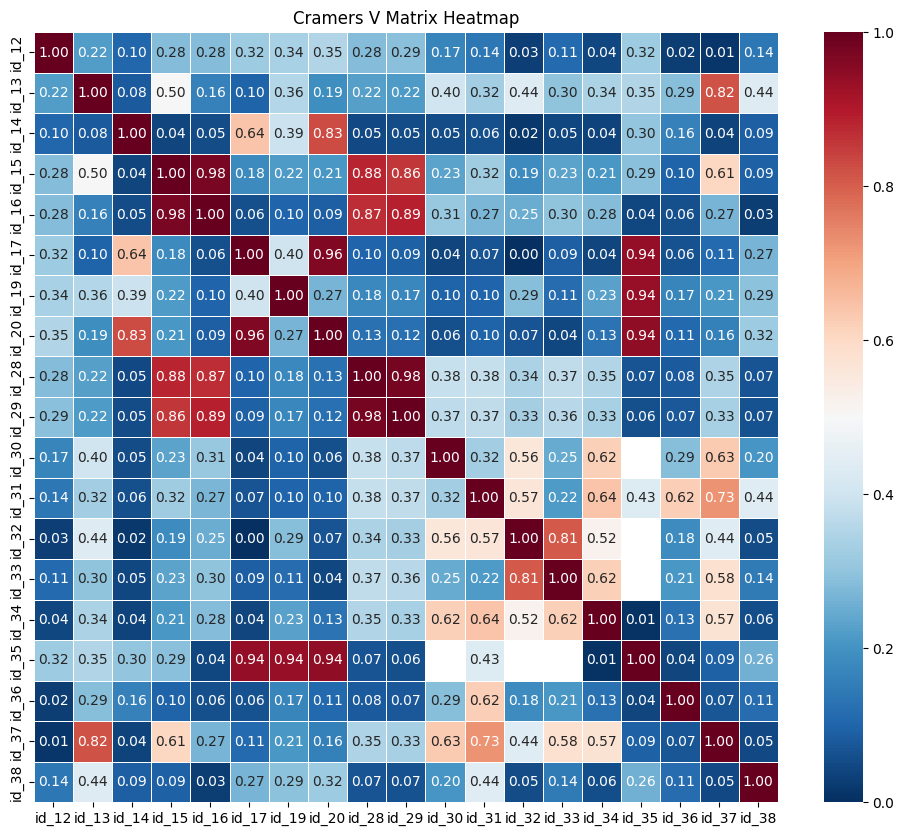

In [317]:
id_columns = train.loc[:, 'id_12':'id_38']

# Create an empty DataFrame to store the results
cramers_v_matrix = pd.DataFrame(index=id_columns.columns, columns=id_columns.columns, dtype=float)

# Fill in the Cramers V values for each pair of columns
for col1 in id_columns.columns:
    for col2 in id_columns.columns:
        cramers_v_matrix.loc[col1, col2] = cramers_v(id_columns[col1], id_columns[col2])

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_v_matrix, cmap='RdBu_r', annot=True, fmt=".2f", linewidths=.5)
plt.title('Cramers V Matrix Heatmap')
plt.show()

In [318]:
# We want to remove collinear features in 'id_' columns with a threshold of 0.75
id_columns = [col for col in train.columns if re.search('^id_(12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38)', col)]
drop_columns = identify_collinear_categorical_features(train, id_columns, threshold=0.75)

# Display the columns to drop
print("Columns to drop:", drop_columns)


Columns to drop: ['id_37', 'id_16', 'id_20', 'id_29', 'id_35', 'id_28', 'id_33']


In [319]:
# Remove the collinear features
train = remove_collinear_categorical_features(train, drop_columns)
test = remove_collinear_categorical_features(test, drop_columns)

In [320]:
# Select only the columns that start with 'id_' and end with a number between 12 and 38
remaining_features = [col for col in train.columns if col.startswith('id_') and col[3:].isdigit() and 12 <= int(col[3:]) <= 38 and col not in ['id_35', 'id_29', 'id_20', 'id_33', 'id_28', 'id_16']]

for col in remaining_features:
    distinct_count = train[col].nunique()
    
    if distinct_count < 200:
        # Target encode using target mean
        temp_dict = train.groupby([col])['isFraud'].agg(['mean']).to_dict()['mean']
        train[col + '_target_encoded'] = train[col].replace(temp_dict)
        test[col + '_target_encoded'] = test[col].replace(temp_dict)
    else:
        # Frequency encode
        train, test = frequency_encoding(train, test, columns=[col])

# Display the first few rows of the modified data
print(train.head())
print(test.head())


               isFraud  TransactionDT  TransactionAmt  dist1   C5   C13  \
TransactionID                                                             
2987000              0          86400            68.5   19.0  0.0   1.0   
2987001              0          86401            29.0    NaN  0.0   1.0   
2987002              0          86469            59.0  287.0  0.0   1.0   
2987003              0          86499            50.0    NaN  0.0  25.0   
2987004              0          86506            50.0    NaN  0.0   1.0   

                  D1     D2    D3    D4  ...  id_14_target_encoded  \
TransactionID                            ...                         
2987000         14.0    NaN  13.0   NaN  ...                   NaN   
2987001          0.0    NaN   NaN   0.0  ...                   NaN   
2987002          0.0    NaN   NaN   0.0  ...                   NaN   
2987003        112.0  112.0   0.0  94.0  ...                   NaN   
2987004          0.0    NaN   NaN   NaN  ...          

In [321]:
# Drop the original columns
train.drop(remaining_features, axis=1, inplace=True)
test.drop(remaining_features, axis=1, inplace=True)

In [322]:
pd.DataFrame(train.dtypes).to_clipboard()

#### DeviceType (nominal categoric)

In [323]:
for df in [train, test]:
  column_details(regex='DeviceType', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DeviceType:  object, 2, %74.62
['desktop' 'mobile' nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DeviceType:  object, 2, %80.75
['desktop' 'mobile' nan]



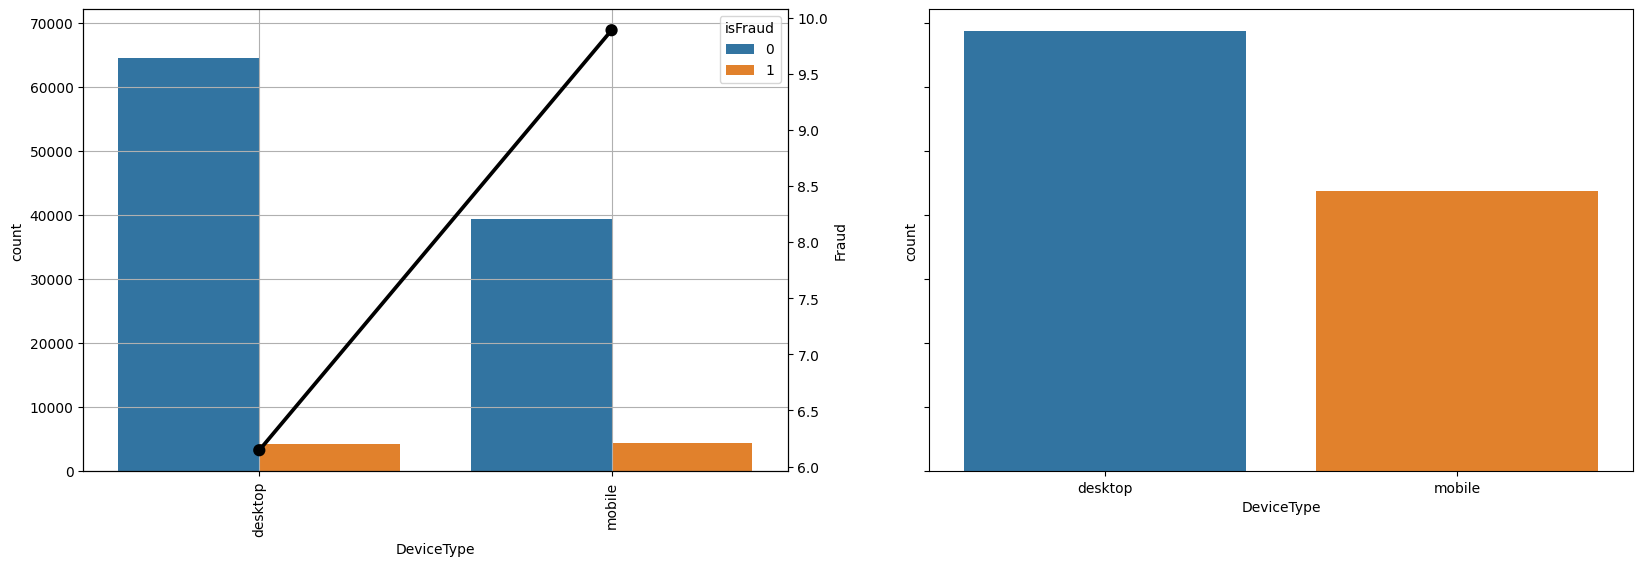

In [324]:
plot_col('DeviceType', df=train)

In [325]:
fraud_rates_device_type = train.groupby('DeviceType')['isFraud'].mean().reset_index()
fraud_rates_device_type.rename(columns={'isFraud': 'FraudRate'}, inplace=True)
fraud_rates_device_type.sort_values(by='FraudRate', ascending=False, inplace=True)

print(fraud_rates_device_type)


  DeviceType  FraudRate
1     mobile   0.098887
0    desktop   0.061458


In [326]:
#target encoding
col = 'DeviceType'
temp_dict = train.groupby([col])['isFraud'].agg(['mean']).to_dict()['mean']
train[col+'_target_encoded'] = train[col].replace(temp_dict)
test[col+'_target_encoded'] = test[col].replace(temp_dict)

In [327]:
# Drop the original column
train.drop('DeviceType', axis=1, inplace=True)
test.drop('DeviceType', axis=1, inplace=True)

#### DeviceInfo(nominal categoric)

In [328]:
for df in [train, test]:
  column_details(regex='DeviceInfo', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DeviceInfo:  object, 1583, %78.49
['0PAJ5' '0PJA2' '0PM92' ... 'verykools5035' 'xs-Z47b7VqTMxs' nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DeviceInfo:  object, 962, %84.16
['2PYB2' '4009F' '4013M Build/KOT49H' '4047A Build/NRD90M'
 '4047G Build/NRD90M' '47418' '5010G Build/MRA58K' '5010S Build/MRA58K'
 '5011A Build/NRD90M' '5012G Build/MRA58K' '5015A Build/LMY47I'
 '5025G Build/LMY47I' '5044A' '5049W Build/NRD90M' '5051A Build/MMB29M'
 '5054S Build/LMY47V' '5056A Build/MMB29M' '5056N' '5080A Build/MRA58K'
 '5085B Build/MRA58K' '6037B' '6039A Build/LRX22G' '6045I Build/LRX22G'
 '6055B' '7048A Build/LRX22G' '7_Plus' '8050G Build/LMY47I'
 '8080 Build/LRX21M' '9008A Build/NRD90M' 'A0001' 'A3-A20' 'A463BG'
 'A574BL Build/NMF26F' 'A577VL' 'AERIAL' 'AKUS' 'ALCATEL'
 'ALCATEL ONE TOUCH 7047A Build/JDQ39' 'ALE-L21 Build/HuaweiALE-L21'
 'ALE-L23 Build/HuaweiALE-L23' 'ALP-L09 Build/HUAWEIALP-L09'
 'AL

In [329]:
# Frequency encoding for DeviceInfo
self_encode_False=['DeviceInfo']
train, test = frequency_encoding(train, test, self_encode_False, self_encoding=False)

In [330]:
# Drop the original column
train.drop('DeviceInfo', axis=1, inplace=True)
test.drop('DeviceInfo', axis=1, inplace=True)

In [331]:
gc.collect()

34084

#### Pickling Final Train and Test

In [332]:
#pickling datasets
#Save 'train' data to a pickle file named 'train_1=3.pkl'
train.to_pickle(r'../dataset/train_3.pkl')

#save 'test' data to a pickle file named 'test_3.pkl'
test.to_pickle(r'../dataset/test_3.pkl')


In [333]:
import pandas as pd
# Read the 'train_3.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('../dataset/train_3.pkl')

# Read the 'test_3.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('../dataset/test_3.pkl')

#### Removing Date columns

In [334]:
# Date columns are not indicators
train.drop('TransactionDT', axis=1, inplace=True)
train.drop('DT', axis=1, inplace=True)

test.drop('TransactionDT', axis=1, inplace=True)
test.drop('DT', axis=1, inplace=True)

In [335]:
pd.DataFrame(train.columns).to_clipboard()

In [336]:
# We have 128 independent variables 1 dependent variable last.
len(train.columns)

128

In [337]:
info = train.dtypes
info.to_clipboard()

#### Defining X sets and Y

In [338]:
# Target variable for training set (y_train)
y_train = train['isFraud']

# Independent variables for training set (X_train)
X_train = train.drop(['isFraud'], axis=1)

# Target variable for test set (y_test)
y_test = test['isFraud']

# Independent variables for test set (X_test)
X_test = test.drop(['isFraud'], axis=1)

#### Default Model

In [339]:
# Get the count of negative and positive examples
count_negative = (y_train == 0).sum()
count_positive = (y_train == 1).sum()

# Calculate the value of scale_pos_weight
scale_pos_weight = math.sqrt(count_negative / count_positive)

In [340]:
#XGBoost with default parameters
xgb = XGBClassifier(objective='binary:logistic', random_state=1003, eval_metric='auc', scale_pos_weight=scale_pos_weight)
xgb.fit(X_train, y_train)

#prediction
y_pred_xgb = xgb.predict(X_test)

#classification report
print(classification_report(y_test, y_pred_xgb))

#confusion matrix
print(confusion_matrix(y_test, y_pred_xgb, normalize='true'))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    142535
           1       0.50      0.42      0.46      5100

    accuracy                           0.97    147635
   macro avg       0.74      0.70      0.72    147635
weighted avg       0.96      0.97      0.96    147635

[[0.98502824 0.01497176]
 [0.57686275 0.42313725]]


In [341]:
# Probas for train
y_train_xgb_proba = xgb.predict_proba(X_train)[:, 1]  
train_auc = roc_auc_score(y_train, y_train_xgb_proba)
print(f'Train AUC: {train_auc}')

# Probas for test
y_pred_xgb_proba = xgb.predict_proba(X_test)[:, 1]  
test_auc = roc_auc_score(y_test, y_pred_xgb_proba)
print(f'Test AUC: {test_auc}')


Train AUC: 0.9625262580415187
Test AUC: 0.8849532849516837


In [342]:
# Feature Importance
cols = list( X_train.columns)
feature_imp = pd.DataFrame(sorted(zip(xgb.feature_importances_, cols), key=lambda x: x[0], reverse=True), columns=['Value', 'Feature'])
feature_imp.to_clipboard()

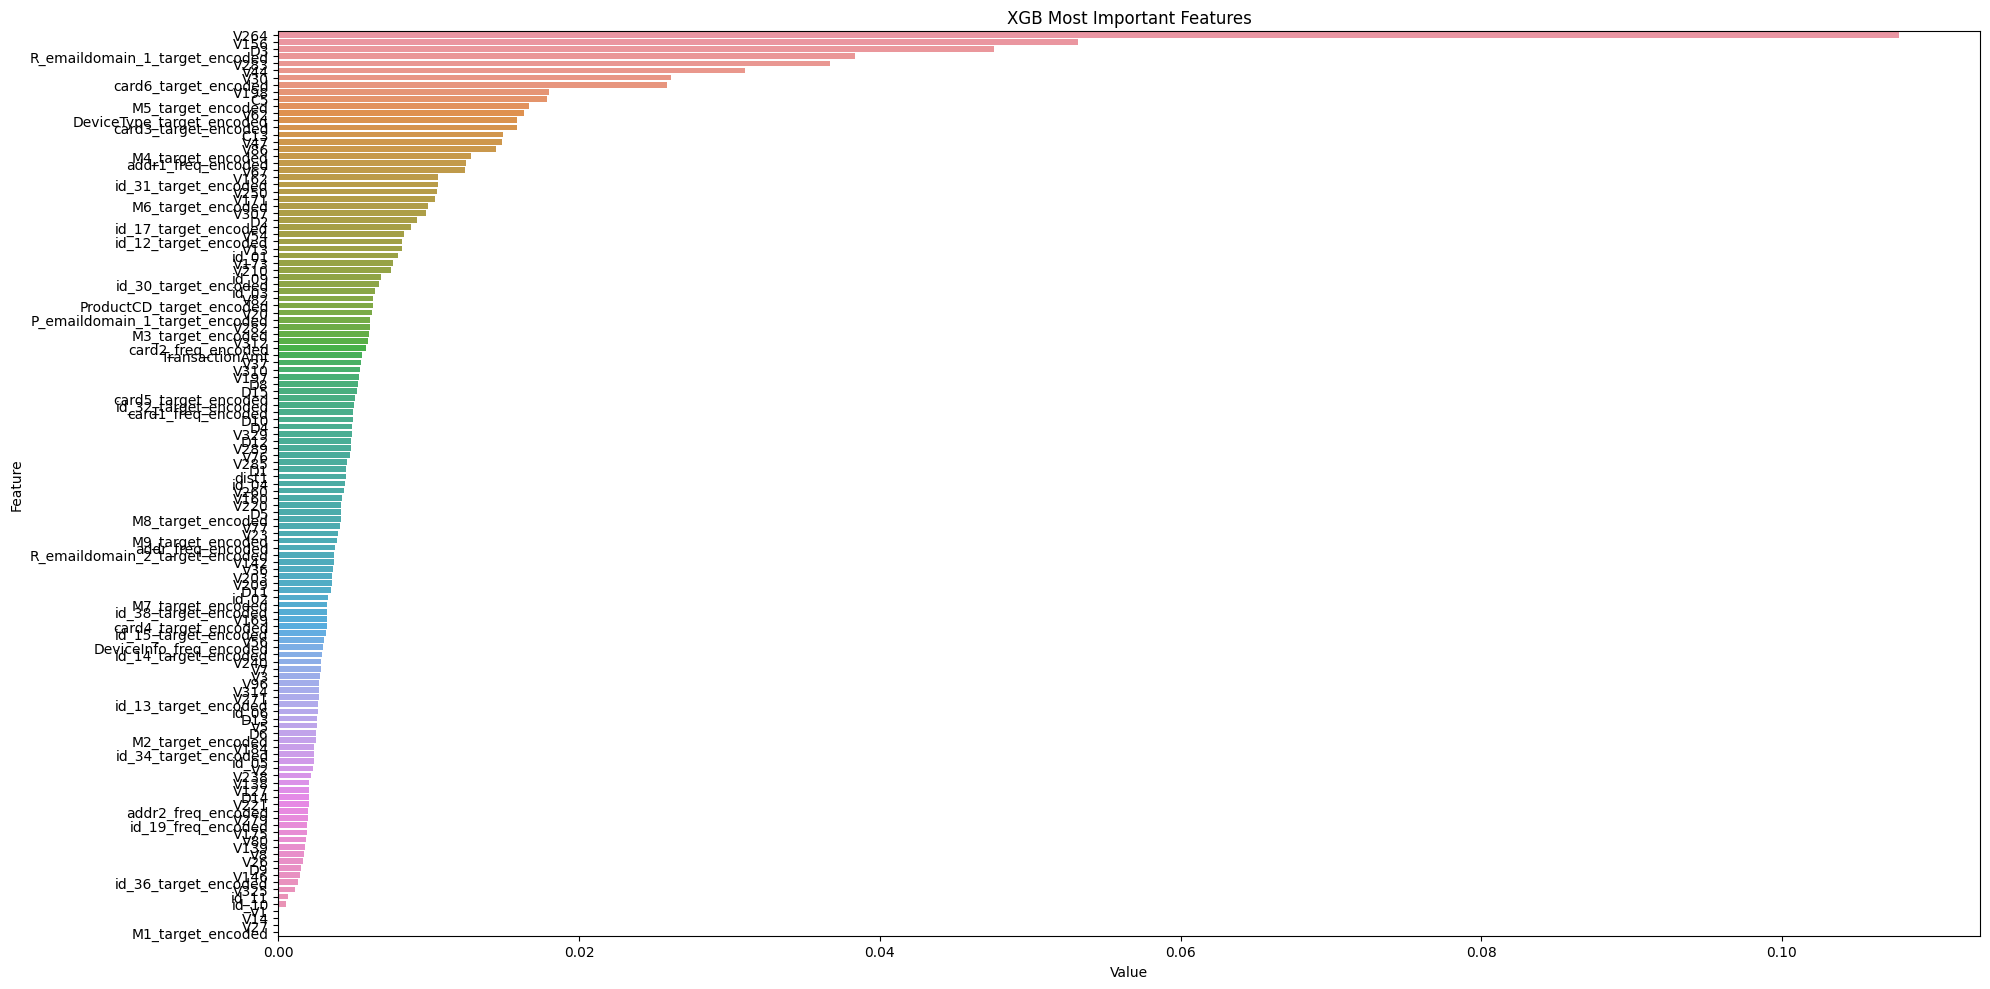

In [343]:
# Plotting feature importance with all variables (127 vars)
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGB Most Important Features')
plt.tight_layout()
plt.show()

#### Second Model with first 50 important features and default parameters

In [344]:
# Select the top 50 important features from X_train
selected_features = feature_imp.head(50)['Feature'].tolist()

# Creating new x dataframes
X_train_2 = X_train[selected_features]
X_test_2 = X_test[selected_features]

In [345]:
# Run the default model with the new feature set
#XGBoost with default parameters
xgb_2 = XGBClassifier(objective='binary:logistic', random_state=1003, eval_metric='auc', scale_pos_weight=scale_pos_weight)
xgb_2.fit(X_train_2, y_train) # fitting with X_train_2

#prediction
y_pred_xgb_2 = xgb_2.predict(X_test_2)

#classification report
print(classification_report(y_test, y_pred_xgb_2))

#confusion matrix
print(confusion_matrix(y_test, y_pred_xgb_2, normalize='true'))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    142535
           1       0.47      0.41      0.44      5100

    accuracy                           0.96    147635
   macro avg       0.73      0.70      0.71    147635
weighted avg       0.96      0.96      0.96    147635

[[0.98364612 0.01635388]
 [0.58705882 0.41294118]]


In [346]:
# Probas for train
y_train_xgb_proba_2 = xgb_2.predict_proba(X_train_2)[:, 1]  
train_auc = roc_auc_score(y_train, y_train_xgb_proba_2)
print(f'Train AUC: {train_auc}')

# Probas for test
y_pred_xgb_proba_2 = xgb_2.predict_proba(X_test_2)[:, 1]  
test_auc = roc_auc_score(y_test, y_pred_xgb_proba_2)
print(f'Test AUC: {test_auc}')


Train AUC: 0.9514796162751223
Test AUC: 0.8728808582962423


In [347]:
# Feature Importance
cols = list( X_train_2.columns)
feature_imp = pd.DataFrame(sorted(zip(xgb_2.feature_importances_, cols), key=lambda x: x[0], reverse=True), columns=['Value', 'Feature'])
feature_imp.to_clipboard()

#### Third Model with first 40 important features and default parameters

In [348]:
# Select the top 30 important features from X_train
selected_features = feature_imp.head(40)['Feature'].tolist()

# Creating new x dataframes
X_train_3 = X_train[selected_features]
X_test_3 = X_test[selected_features]

In [349]:
# Run the default model with the new feature set
#XGBoost with default parameters
xgb_3 = XGBClassifier(objective='binary:logistic', random_state=1003, eval_metric='auc', scale_pos_weight=scale_pos_weight)
xgb_3.fit(X_train_3, y_train) # fitting with X_train_2

#prediction
y_pred_xgb_3 = xgb_3.predict(X_test_3)

#classification report
print(classification_report(y_test, y_pred_xgb_3))

#confusion matrix
print(confusion_matrix(y_test, y_pred_xgb_3, normalize='true'))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    142535
           1       0.45      0.42      0.44      5100

    accuracy                           0.96    147635
   macro avg       0.72      0.70      0.71    147635
weighted avg       0.96      0.96      0.96    147635

[[0.98182201 0.01817799]
 [0.58019608 0.41980392]]


In [350]:
# Probas for train
y_train_xgb_proba_3 = xgb_3.predict_proba(X_train_3)[:, 1]  
train_auc = roc_auc_score(y_train, y_train_xgb_proba_3)
print(f'Train AUC: {train_auc}')

# Probas for test
y_pred_xgb_proba_3 = xgb_3.predict_proba(X_test_3)[:, 1]  
test_auc = roc_auc_score(y_test, y_pred_xgb_proba_3)
print(f'Test AUC: {test_auc}')


Train AUC: 0.9501872964334457
Test AUC: 0.8720227291955123


In [351]:
# Feature Importance
cols = list( X_train_3.columns)
feature_imp = pd.DataFrame(sorted(zip(xgb_3.feature_importances_, cols), key=lambda x: x[0], reverse=True), columns=['Value', 'Feature'])
feature_imp.to_clipboard()

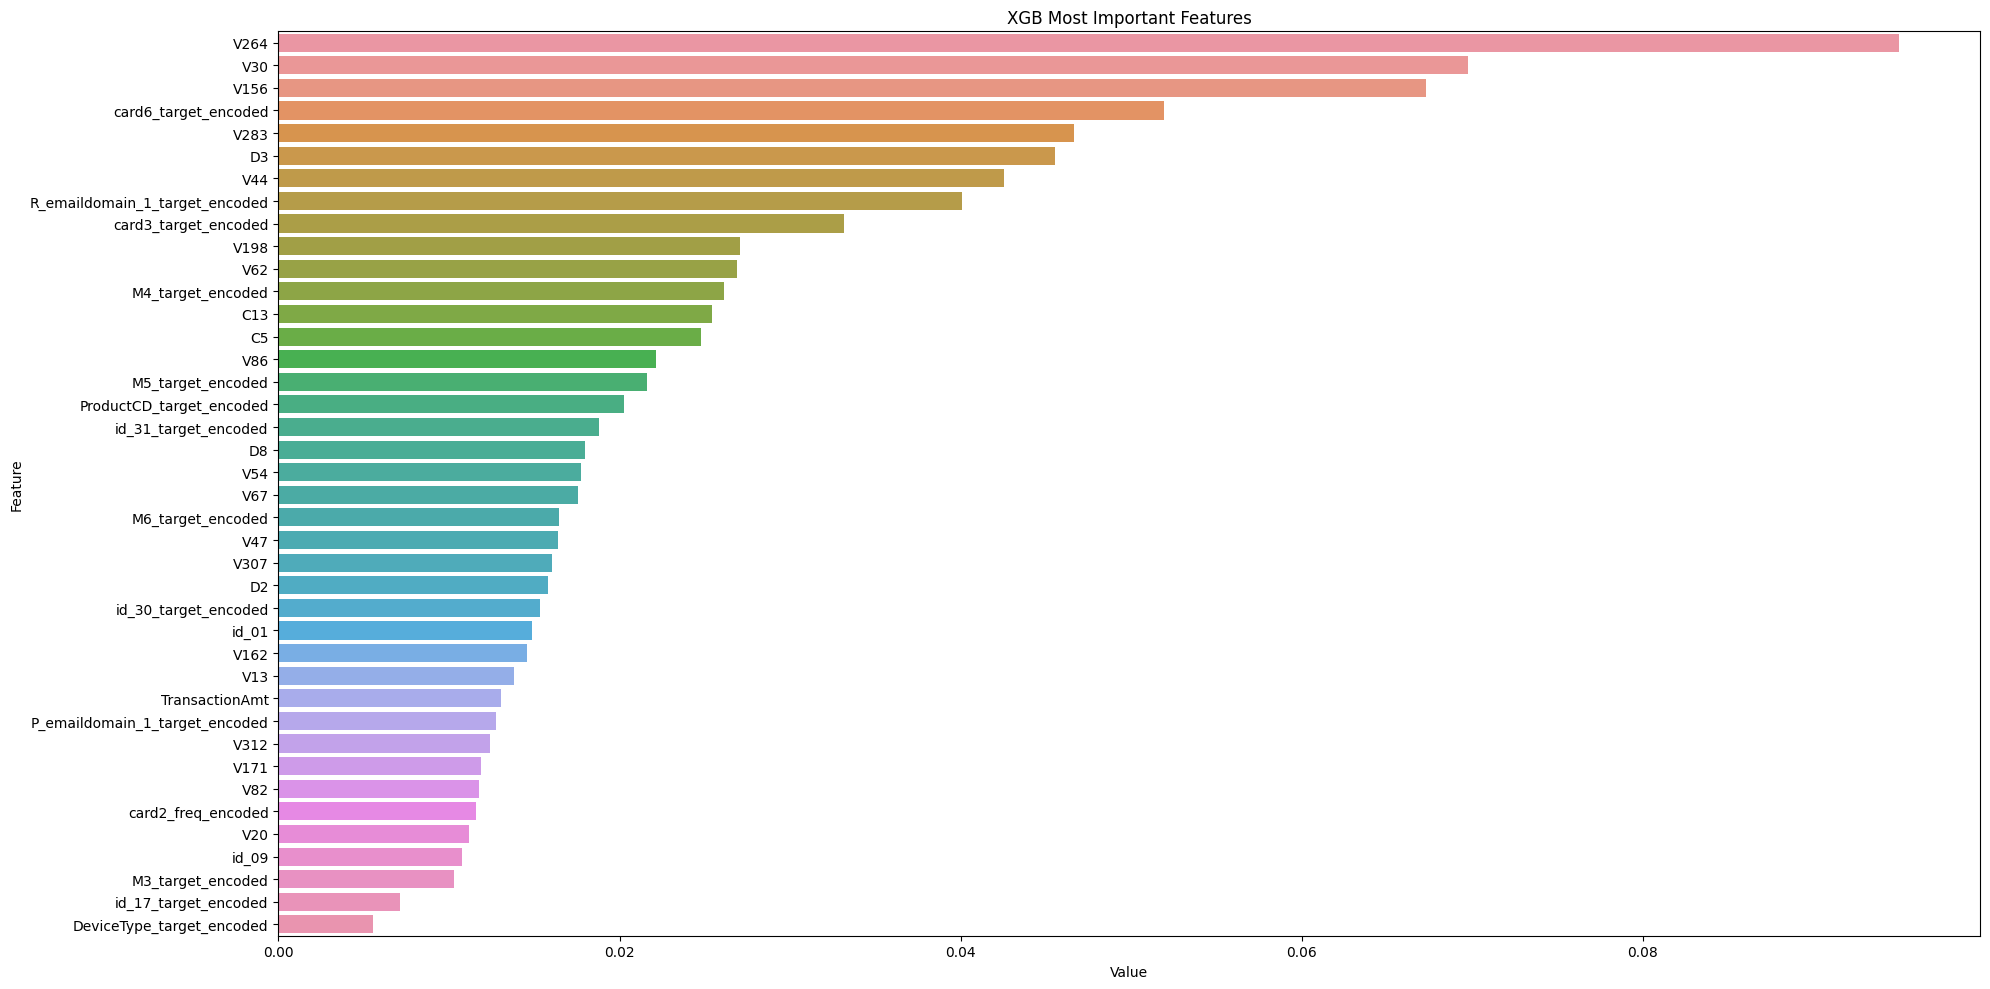

In [352]:
# Plotting feature importance with selected 40 params
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGB Most Important Features')
plt.tight_layout()
plt.show()

In [355]:
# saving the model to use in web API
import joblib
filename = f'models/model_xgbv3_joblib'
joblib.dump(xgb_3, filename+".pkl")

# getting the description of dataset and saving
description = X_train_3.describe()
description.to_csv(filename+'_describe_X.csv')

description = y_train.describe()
description.to_csv(filename+'_describe_y.csv')